# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle
import networkx as nx


In [2]:
import torch

if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    device = torch.device("cuda")  # Set device to CUDA if available
    print(f"Using device: {device}")
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA version: {torch.version.cuda}")  # CUDA version PyTorch was compiled with
    print(f"cuDNN version: {torch.backends.cudnn.version()}")  # cuDNN version
    print(f"Number of GPUs: {torch.cuda.device_count()}")  # GPU count
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # GPU name

CUDA available: True
Using device: cuda
Torch version: 2.4.0+cu124
CUDA version: 12.4
cuDNN version: 90100
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 2080 Ti


In [3]:
import dgl
# Print the installed DGL version
print(f"DGL version: {dgl.__version__}")
print(dgl.backend.backend_name)

DGL version: 2.4.0+cu124
pytorch


# PCN Graph Generation

In [4]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle


# ------------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------------

# Take ROOT file and convert to an awkward array
def fileToAwk(path):
    file = uproot.open(path)
    tree = file['tree']
    awk = tree.arrays(tree.keys())
    return awk

# Features used to train the model
input_features = [
    "part_px", "part_py", "part_pz", "part_energy",
    "part_deta", "part_dphi", "part_d0val", "part_d0err",
    "part_dzval", "part_dzerr", "part_isChargedHadron", "part_isNeutralHadron",
    "part_isPhoton", "part_isElectron", "part_isMuon"
]

# Take AWK dict and convert to a point cloud
def awkToPointCloud(awkDict, input_features):
    featureVector = []
    for jet in tqdm(range(len(awkDict)), total=len(awkDict)):
        currJet = awkDict[jet][input_features]
        try:
            pT = np.sqrt(ak.to_numpy(currJet['part_px']) ** 2 + ak.to_numpy(currJet['part_py']) ** 2)
            # Create numpy array to represent the 4-momenta of all particles in a jet
            currJet = np.column_stack((
                ak.to_numpy(currJet['part_px']),
                ak.to_numpy(currJet['part_py']),
                ak.to_numpy(currJet['part_pz']),
                ak.to_numpy(currJet['part_energy']),
                pT,
                ak.to_numpy(currJet['part_deta']),
                ak.to_numpy(currJet['part_dphi']),
                ak.to_numpy(currJet["part_d0val"]),
                ak.to_numpy(currJet["part_d0err"]),
                ak.to_numpy(currJet["part_dzval"]),
                ak.to_numpy(currJet["part_dzerr"]),
                ak.to_numpy(currJet["part_isChargedHadron"]),
                ak.to_numpy(currJet["part_isNeutralHadron"]),
                ak.to_numpy(currJet["part_isPhoton"]),
                ak.to_numpy(currJet["part_isElectron"]),
                ak.to_numpy(currJet["part_isMuon"])
            ))
            featureVector.append(currJet)
        except Exception as e:
            print(f"Error processing jet {jet}: {e}")
            featureVector.append(np.empty((0, len(input_features) + 1)))  # Add an empty array for failed jets
    return featureVector  # Return a list of arrays instead of a single numpy array

# Build a KNN graph from a point cloud
def buildKNNGraph(points, k):
    tree = cKDTree(points)
    dists, indices = tree.query(points, k+1)  # +1 to exclude self

    num_points = len(points)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in indices[i, 1:]:  # exclude self
            adj_matrix[i, j] = 1
            # adj_matrix[j, i] = 1
    return adj_matrix

# Convert adjacency matrix to a DGL graph
def adjacencyToDGL(adj_matrix):
    adj_matrix = sp.coo_matrix(adj_matrix)
    g_dgl = dgl.from_scipy(adj_matrix)
    return g_dgl

# Wrap the functionality of fileToAwk and awkToPointCloud into a single function
def fileToPointCloudArray(jetType, input_features):
    # filepath = f'/Volumes/Yash SSD/JetClass/JetRoots/{jetType}_000.root'  # original ROOT file
    filepath = f'./data/JetClass/JetRoots/JetClass_example_100k.root'  # original ROOT file
    savepath = f'./data/JetClass/PointClouds/{jetType}.npy'   # save file
    awk = fileToAwk(filepath)
    nparr = awkToPointCloud(awk, input_features)
    return nparr

# Combine all steps: read file → build adjacency → build DGL graph → optionally save
def fileToGraph(jetType, k=5, save=True):
    print(f'Starting processing on {jetType} jets')
    pointCloudArr = fileToPointCloudArray(jetType, input_features)
    saveFilePath = f'./data/Multi Level Jet Tagging/{jetType}.pkl'

    savedGraphs = []
    for idx, pointCloud in tqdm(enumerate(pointCloudArr), leave=False, total=len(pointCloudArr)):
        try:
            adj_matrix = buildKNNGraph(pointCloud, k)
            graph = adjacencyToDGL(adj_matrix)
            graph.ndata['feat'] = torch.tensor(pointCloud, dtype=torch.float32)
            savedGraphs.append(graph)

            # Cleanup
            del adj_matrix, graph
        except Exception as e:
            print(e)

    if save:
        with open(saveFilePath, 'wb') as f:
            pickle.dump(savedGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)

        del pointCloudArr, savedGraphs

    print(f'Graphs for {jetType} processing complete!')
    return savedGraphs

def groupToGraph(jetTypeList, groupName):
    allGraphs = []
    for jetType in jetTypeList:
        allGraphs += fileToGraph(jetType, save=False)

    saveFilePath = f'./data/Multi Level Jet Tagging/{groupName}.pkl'
    with open(saveFilePath, 'wb') as f:
        pickle.dump(allGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)
    return allGraphs

# ------------------------------------------------------------------
# MAIN EXECUTION (example usage)
# ------------------------------------------------------------------

# Example lists of jet types
Higgs = ['HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q']
Vector = ['WToQQ', 'ZToQQ']
Top = ['TTBar', 'TTBarLep']
QCD = ['ZJetsToNuNu']
Emitter = ['Emitter-Vector', 'Emitter-Top', 'Emitter-Higgs', 'Emitter-QCD']
allJets = Higgs + Vector + Top + QCD

# If you want to process all jets, you could uncomment:
# for jetType in allJets:
#     fileToGraph(jetType)

# Example: build a group of Higgs graphs
allGraphs = groupToGraph(Higgs, "Emitter-Higgs")

# Save them
with open(f'./data/Multi Level Jet Tagging/Emitter-Higgs.pkl', 'wb') as f:
    pickle.dump(allGraphs, f)

print("DONE")


Starting processing on HToBB jets


 31%|███       | 30613/100000 [00:11<00:24, 2867.37it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 32%|███▏      | 32242/100000 [00:11<00:21, 3186.28it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 33%|███▎      | 32571/100000 [00:11<00:20, 3216.60it/s]

index 5 is out of bounds for axis 1 with size 5


 34%|███▎      | 33550/100000 [00:12<00:24, 2660.72it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 35%|███▍      | 34839/100000 [00:12<00:21, 3052.06it/s]

index 3 is out of bounds for axis 1 with size 3


 36%|███▌      | 35818/100000 [00:13<00:20, 3184.20it/s]

index 4 is out of bounds for axis 1 with size 4


 37%|███▋      | 36809/100000 [00:13<00:19, 3253.17it/s]

index 5 is out of bounds for axis 1 with size 5


 38%|███▊      | 37804/100000 [00:13<00:18, 3295.58it/s]

index 4 is out of bounds for axis 1 with size 4


 38%|███▊      | 38465/100000 [00:13<00:18, 3282.53it/s]

index 4 is out of bounds for axis 1 with size 4


 39%|███▉      | 39450/100000 [00:14<00:18, 3263.47it/s]

index 4 is out of bounds for axis 1 with size 4
index 5 is out of bounds for axis 1 with size 5


 54%|█████▍    | 53789/100000 [00:19<00:14, 3270.64it/s]

index 4 is out of bounds for axis 1 with size 4


 55%|█████▍    | 54777/100000 [00:19<00:13, 3283.16it/s]

index 4 is out of bounds for axis 1 with size 4


 57%|█████▋    | 57115/100000 [00:20<00:12, 3311.56it/s]

index 3 is out of bounds for axis 1 with size 3


 81%|████████  | 80962/100000 [00:28<00:06, 3099.45it/s]

index 5 is out of bounds for axis 1 with size 5


 82%|████████▏ | 81584/100000 [00:29<00:05, 3071.37it/s]

index 5 is out of bounds for axis 1 with size 5


 83%|████████▎ | 82510/100000 [00:29<00:05, 3034.80it/s]

index 5 is out of bounds for axis 1 with size 5


 86%|████████▌ | 86225/100000 [00:30<00:04, 3106.48it/s]

index 5 is out of bounds for axis 1 with size 5


Graphs for HToBB processing complete!
Starting processing on HToCC jets


 31%|███       | 30574/100000 [00:11<00:24, 2796.44it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 31%|███       | 31215/100000 [00:11<00:22, 3002.59it/s]

index 3 is out of bounds for axis 1 with size 3


 33%|███▎      | 32514/100000 [00:11<00:21, 3188.08it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 33%|███▎      | 33169/100000 [00:12<00:20, 3231.68it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 34%|███▍      | 34144/100000 [00:12<00:20, 3228.98it/s]

index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 36%|███▌      | 35777/100000 [00:12<00:19, 3259.79it/s]

index 4 is out of bounds for axis 1 with size 4


 37%|███▋      | 36750/100000 [00:13<00:19, 3177.60it/s]

index 5 is out of bounds for axis 1 with size 5


 38%|███▊      | 37732/100000 [00:13<00:19, 3237.19it/s]

index 4 is out of bounds for axis 1 with size 4


 38%|███▊      | 38386/100000 [00:13<00:18, 3252.58it/s]

index 4 is out of bounds for axis 1 with size 4


 39%|███▉      | 39364/100000 [00:13<00:18, 3239.54it/s]

index 4 is out of bounds for axis 1 with size 4
index 5 is out of bounds for axis 1 with size 5


 54%|█████▍    | 53909/100000 [00:19<00:14, 3237.94it/s]

index 4 is out of bounds for axis 1 with size 4


 55%|█████▍    | 54884/100000 [00:19<00:25, 1741.20it/s]

index 4 is out of bounds for axis 1 with size 4


 57%|█████▋    | 56816/100000 [00:20<00:14, 2947.62it/s]

index 3 is out of bounds for axis 1 with size 3


 81%|████████  | 80943/100000 [00:28<00:06, 3158.23it/s]

index 5 is out of bounds for axis 1 with size 5


 82%|████████▏ | 81573/100000 [00:28<00:05, 3119.01it/s]

index 5 is out of bounds for axis 1 with size 5


 83%|████████▎ | 82526/100000 [00:29<00:05, 3107.40it/s]

index 5 is out of bounds for axis 1 with size 5


 86%|████████▋ | 86327/100000 [00:30<00:04, 3171.67it/s]

index 5 is out of bounds for axis 1 with size 5


Graphs for HToCC processing complete!
Starting processing on HToGG jets


 31%|███       | 30545/100000 [00:10<00:23, 2927.49it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 33%|███▎      | 32551/100000 [00:11<00:20, 3295.06it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 33%|███▎      | 33227/100000 [00:11<00:20, 3338.06it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 34%|███▍      | 34231/100000 [00:11<00:19, 3310.53it/s]

index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 36%|███▌      | 35902/100000 [00:12<00:19, 3328.03it/s]

index 4 is out of bounds for axis 1 with size 4


 37%|███▋      | 36574/100000 [00:12<00:19, 3327.61it/s]

index 5 is out of bounds for axis 1 with size 5


 38%|███▊      | 37585/100000 [00:12<00:18, 3357.05it/s]

index 4 is out of bounds for axis 1 with size 4


 39%|███▊      | 38594/100000 [00:12<00:18, 3339.66it/s]

index 4 is out of bounds for axis 1 with size 4


 40%|███▉      | 39606/100000 [00:13<00:17, 3357.54it/s]

index 4 is out of bounds for axis 1 with size 4
index 5 is out of bounds for axis 1 with size 5


 54%|█████▍    | 53971/100000 [00:18<00:13, 3378.19it/s]

index 4 is out of bounds for axis 1 with size 4


 55%|█████▍    | 54646/100000 [00:18<00:14, 3111.56it/s]

index 4 is out of bounds for axis 1 with size 4


 57%|█████▋    | 56983/100000 [00:19<00:12, 3325.30it/s]

index 3 is out of bounds for axis 1 with size 3


 81%|████████  | 80936/100000 [00:27<00:06, 3110.30it/s]

index 5 is out of bounds for axis 1 with size 5


 82%|████████▏ | 81559/100000 [00:27<00:05, 3099.26it/s]

index 5 is out of bounds for axis 1 with size 5


 82%|████████▏ | 82493/100000 [00:28<00:05, 3104.00it/s]

index 5 is out of bounds for axis 1 with size 5


 86%|████████▌ | 86247/100000 [00:29<00:04, 3136.93it/s]

index 5 is out of bounds for axis 1 with size 5


Graphs for HToGG processing complete!
Starting processing on HToWW2Q1L jets


 31%|███       | 30671/100000 [00:10<00:23, 2984.98it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 32%|███▏      | 32330/100000 [00:11<00:20, 3261.73it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 33%|███▎      | 32996/100000 [00:11<00:20, 3294.72it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 34%|███▍      | 34338/100000 [00:11<00:19, 3299.66it/s]

index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 36%|███▌      | 36016/100000 [00:12<00:19, 3353.04it/s]

index 4 is out of bounds for axis 1 with size 4


 37%|███▋      | 36687/100000 [00:12<00:18, 3346.47it/s]

index 5 is out of bounds for axis 1 with size 5


 38%|███▊      | 37701/100000 [00:12<00:18, 3357.57it/s]

index 4 is out of bounds for axis 1 with size 4


 38%|███▊      | 38374/100000 [00:13<00:18, 3358.69it/s]

index 4 is out of bounds for axis 1 with size 4


 39%|███▉      | 39383/100000 [00:13<00:18, 3352.14it/s]

index 4 is out of bounds for axis 1 with size 4
index 5 is out of bounds for axis 1 with size 5


 54%|█████▍    | 53850/100000 [00:18<00:13, 3387.03it/s]

index 4 is out of bounds for axis 1 with size 4


 55%|█████▍    | 54864/100000 [00:18<00:13, 3356.17it/s]

index 4 is out of bounds for axis 1 with size 4


 57%|█████▋    | 56920/100000 [00:19<00:12, 3420.94it/s]

index 3 is out of bounds for axis 1 with size 3


 81%|████████  | 81093/100000 [00:28<00:05, 3187.43it/s]

index 5 is out of bounds for axis 1 with size 5


 82%|████████▏ | 81729/100000 [00:28<00:05, 3163.63it/s]

index 5 is out of bounds for axis 1 with size 5


 83%|████████▎ | 82684/100000 [00:28<00:05, 3149.00it/s]

index 5 is out of bounds for axis 1 with size 5


 86%|████████▌ | 86180/100000 [00:29<00:04, 3176.36it/s]

index 5 is out of bounds for axis 1 with size 5


Graphs for HToWW2Q1L processing complete!
Starting processing on HToWW4Q jets


 31%|███       | 30592/100000 [00:10<00:23, 2971.87it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 32%|███▏      | 32266/100000 [00:11<00:20, 3286.86it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 33%|███▎      | 32935/100000 [00:11<00:20, 3311.63it/s]

index 5 is out of bounds for axis 1 with size 5
index 5 is out of bounds for axis 1 with size 5


 34%|███▍      | 34261/100000 [00:11<00:20, 3255.47it/s]

index 5 is out of bounds for axis 1 with size 5
index 3 is out of bounds for axis 1 with size 3


 36%|███▌      | 35905/100000 [00:12<00:19, 3270.05it/s]

index 4 is out of bounds for axis 1 with size 4


 37%|███▋      | 36570/100000 [00:12<00:20, 3161.12it/s]

index 5 is out of bounds for axis 1 with size 5


 38%|███▊      | 37568/100000 [00:12<00:19, 3272.79it/s]

index 4 is out of bounds for axis 1 with size 4


 39%|███▊      | 38555/100000 [00:12<00:18, 3275.26it/s]

index 4 is out of bounds for axis 1 with size 4


 40%|███▉      | 39543/100000 [00:13<00:18, 3285.25it/s]

index 4 is out of bounds for axis 1 with size 4
index 5 is out of bounds for axis 1 with size 5


 54%|█████▎    | 53614/100000 [00:18<00:14, 3174.10it/s]

index 4 is out of bounds for axis 1 with size 4


 55%|█████▍    | 54960/100000 [00:19<00:28, 1596.01it/s]

index 4 is out of bounds for axis 1 with size 4


 57%|█████▋    | 57013/100000 [00:20<00:14, 3021.70it/s]

index 3 is out of bounds for axis 1 with size 3


 81%|████████  | 81086/100000 [00:28<00:05, 3191.75it/s]

index 5 is out of bounds for axis 1 with size 5


 82%|████████▏ | 81723/100000 [00:28<00:05, 3144.73it/s]

index 5 is out of bounds for axis 1 with size 5


 83%|████████▎ | 82671/100000 [00:28<00:05, 3149.89it/s]

index 5 is out of bounds for axis 1 with size 5


 86%|████████▌ | 86146/100000 [00:29<00:04, 3154.85it/s]

index 5 is out of bounds for axis 1 with size 5


Graphs for HToWW4Q processing complete!
DONE


# Total Number of Graphs Generated

## Load the File Path

In [2]:
# Load and count the total number of graphs
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'

In [5]:
def count_graphs(file_path):
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
    except Exception as e:
        print(f"Failed to load the file: {e}")

count_graphs(file_path)

/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


File loaded successfully! Total number of graphs: 499890


# First and Last 5 Graphs

/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


File loaded successfully! Total number of graphs: 499890


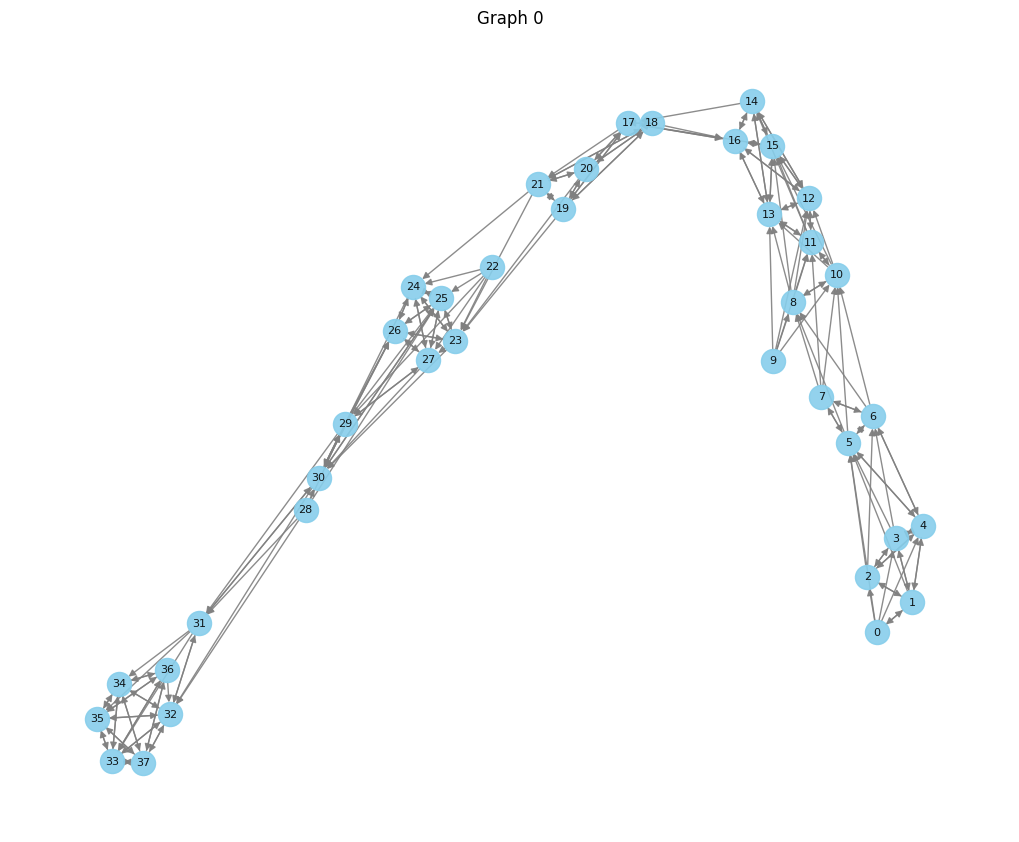

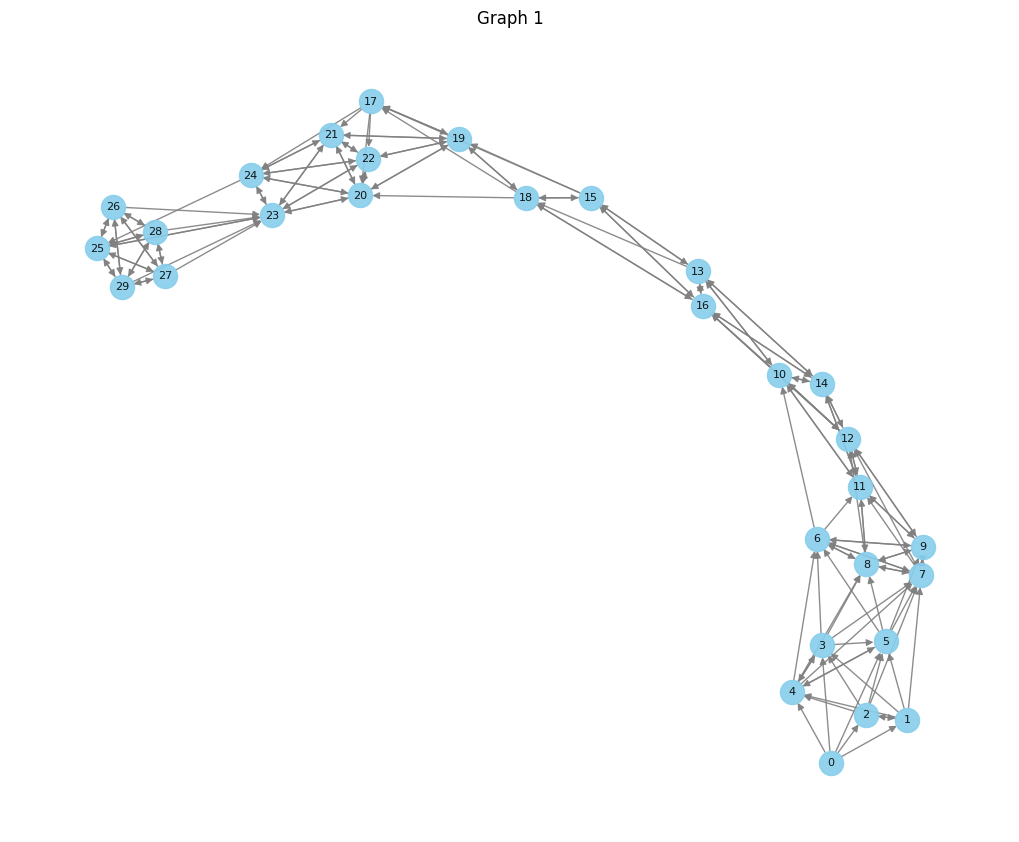

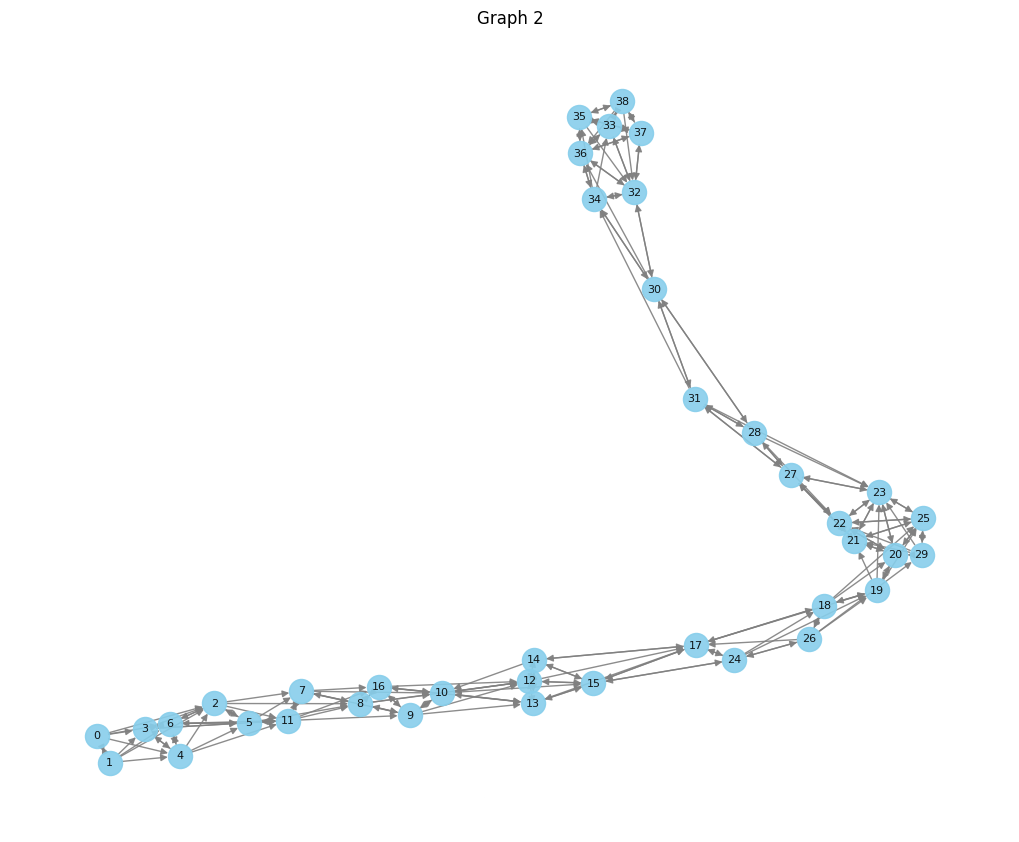

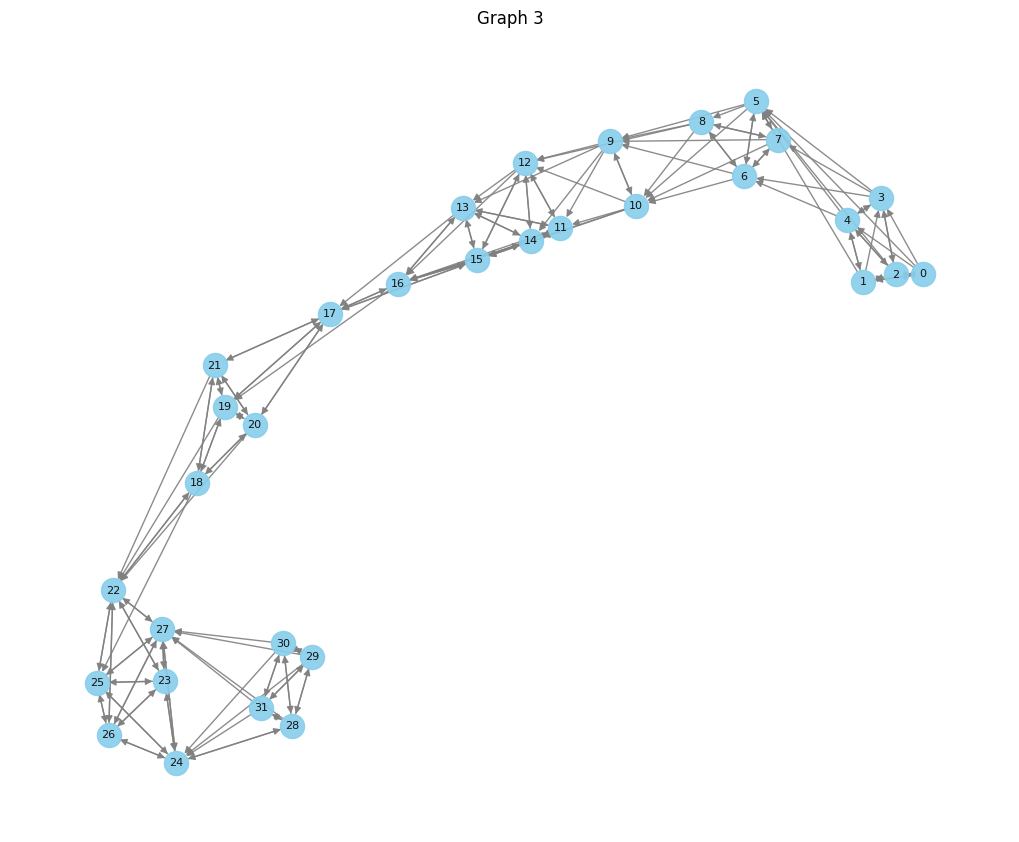

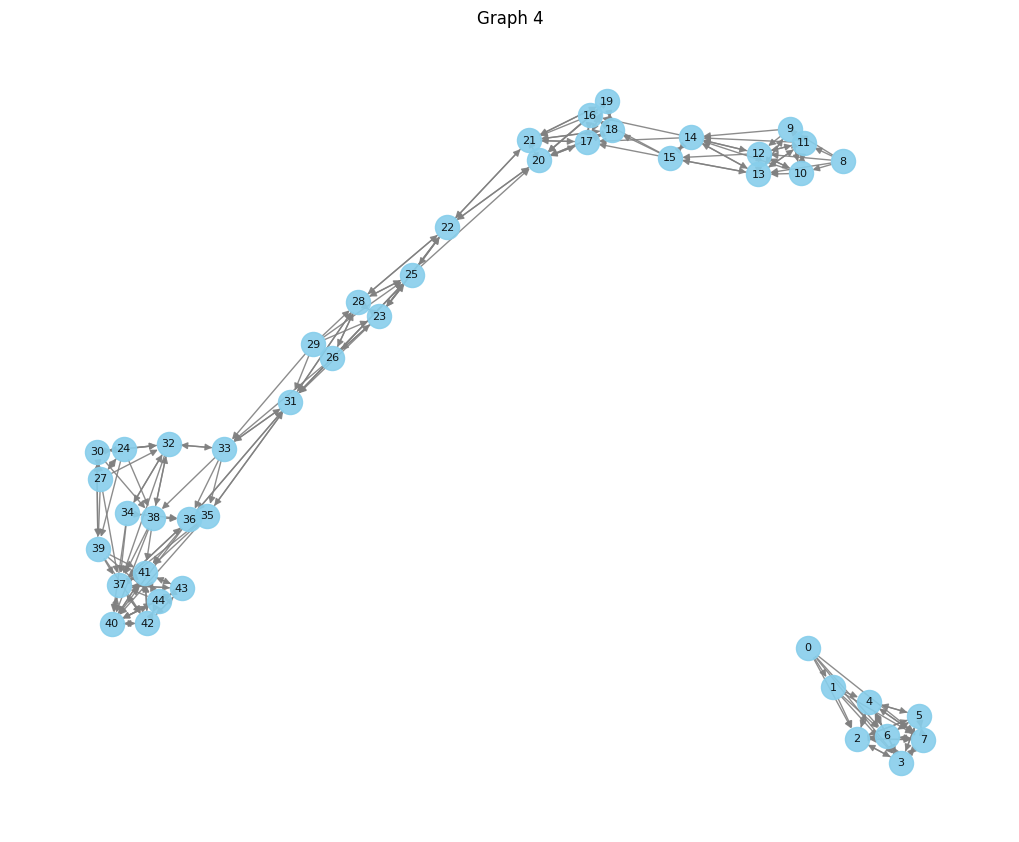

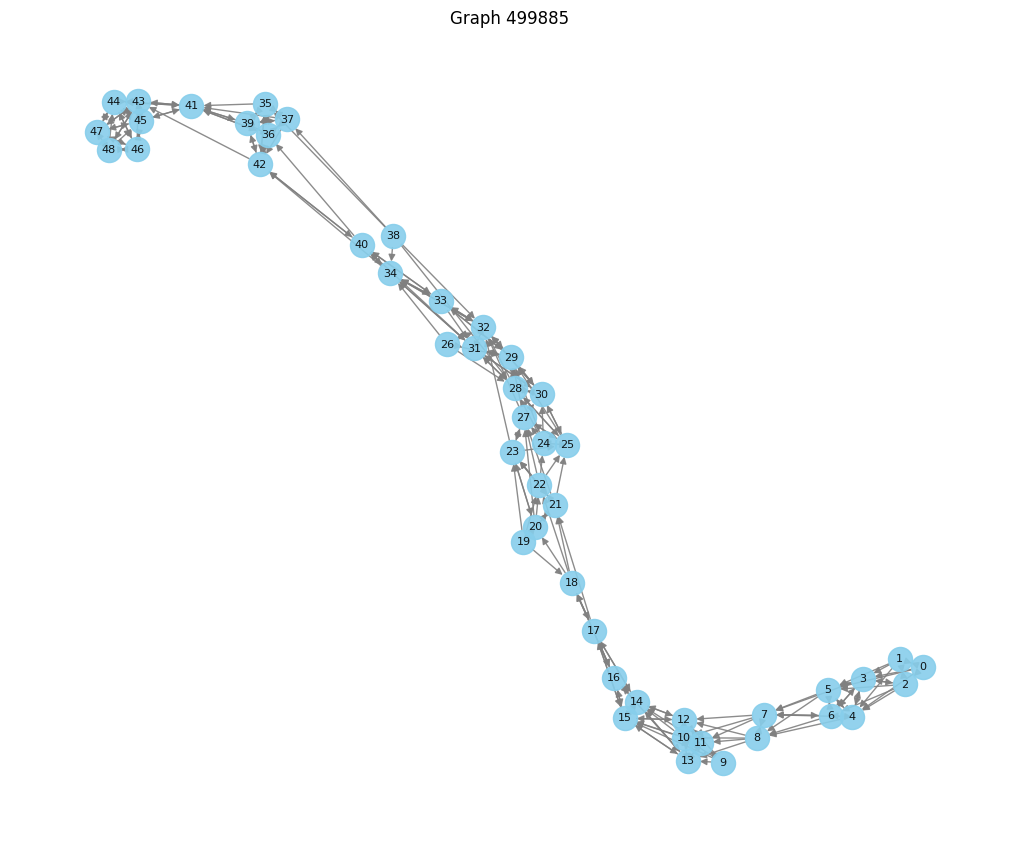

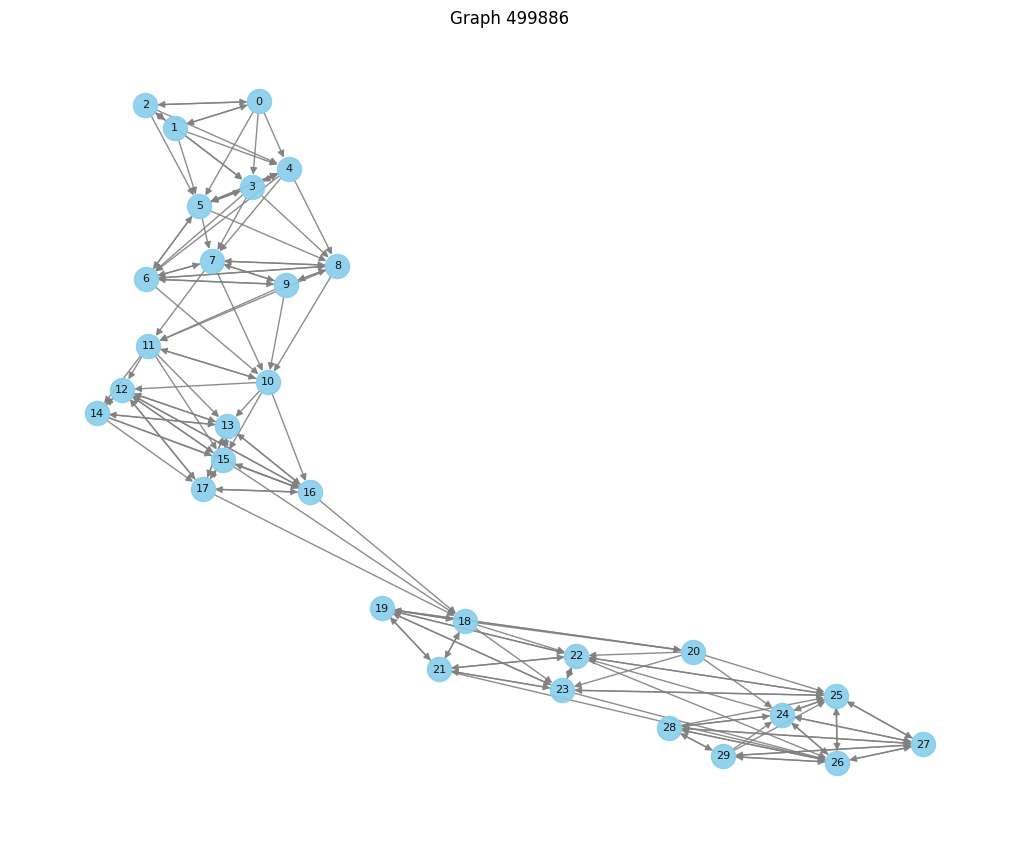

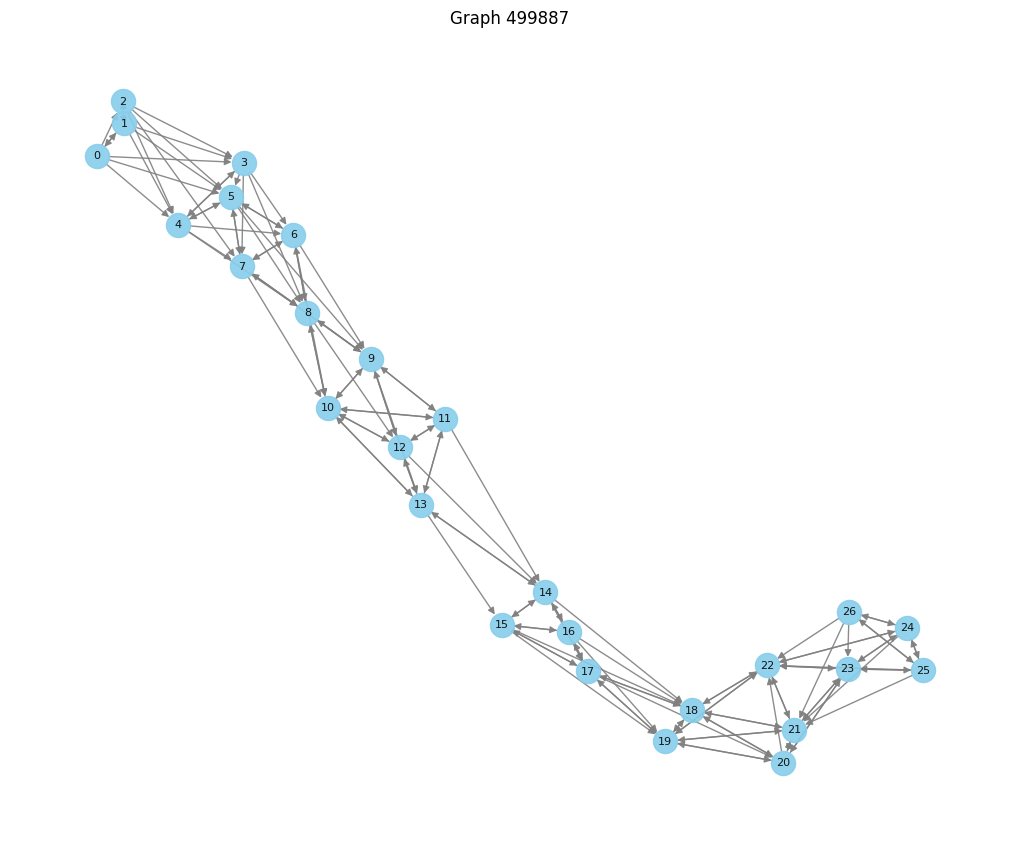

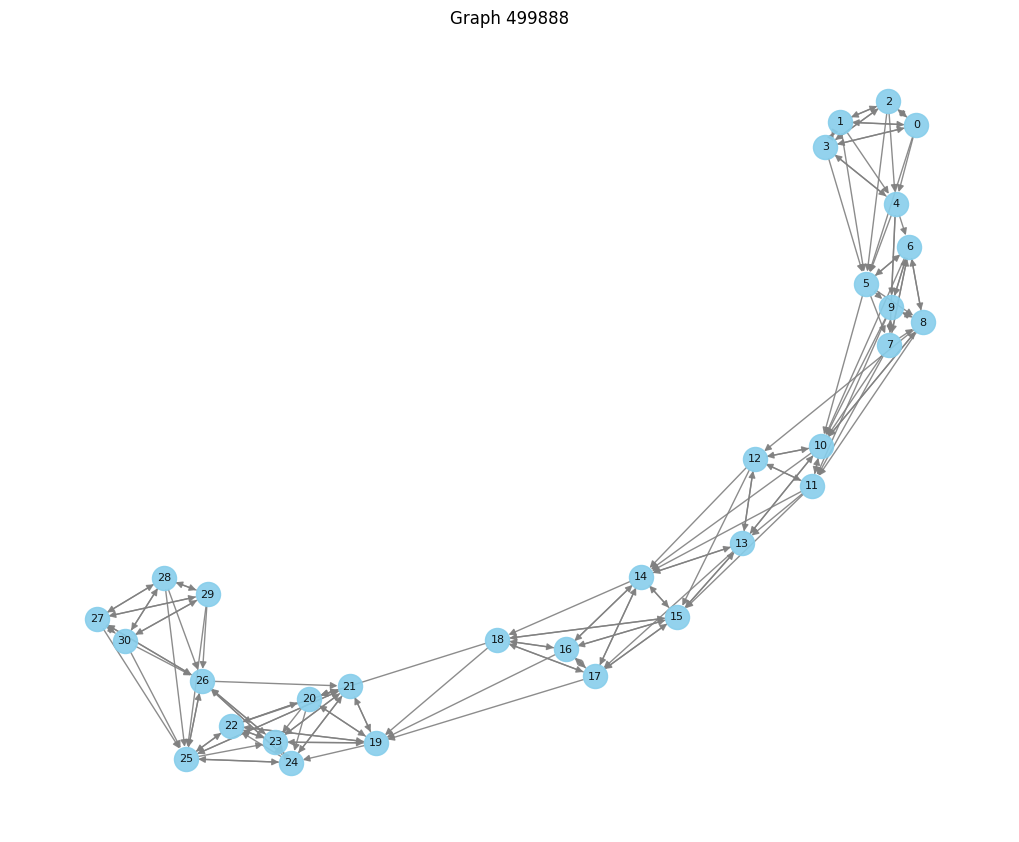

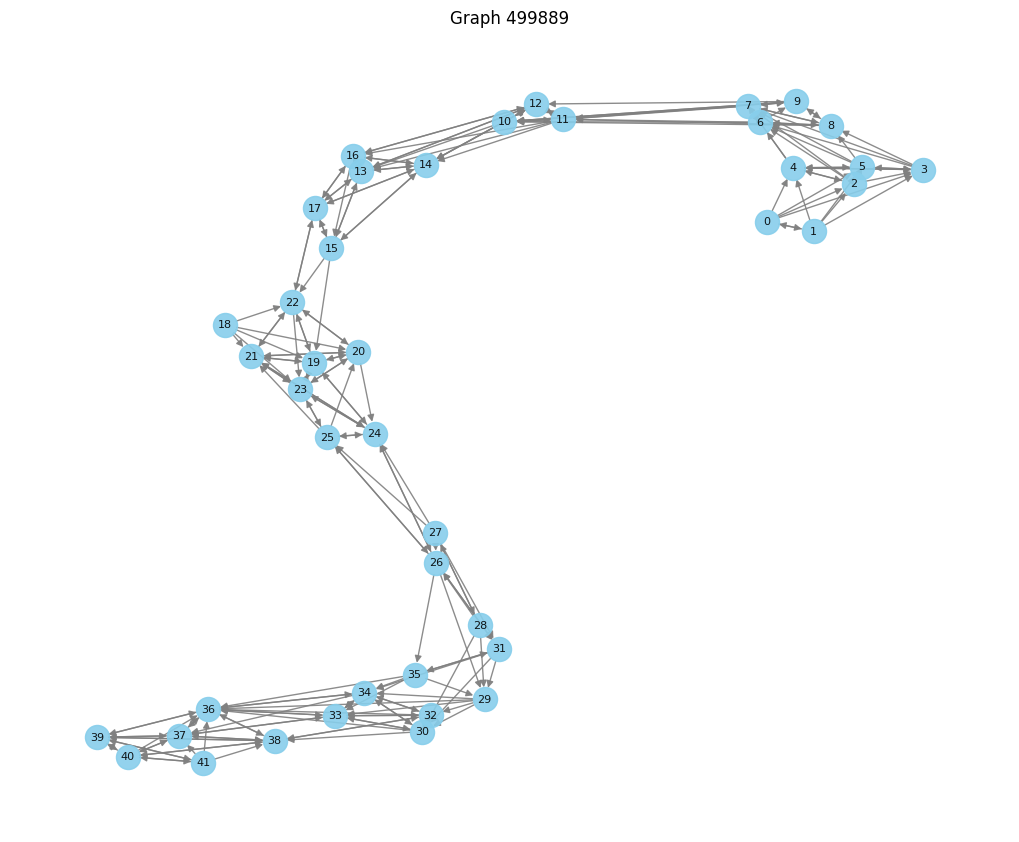

In [5]:
# Part 2: Load and visualize graphs independently
def load_graphs(file_path):
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        return graphs
    except Exception as e:
        print(f"Failed to load the file: {e}")
        return None

def visualize_graph_with_labels(graphs, indices):
    if graphs is None:
        print("No graphs to visualize.")
        return
    
    for idx in indices:
        if idx >= len(graphs) or idx < 0:
            print(f"Index {idx} is out of range.")
            continue
        
        g = graphs[idx]
        nx_graph = g.to_networkx()

        # Layout for better graph organization
        pos = nx.spring_layout(nx_graph)

        plt.figure(figsize=(10, 8))
        nx.draw(
            nx_graph, pos,
            with_labels=True,
            labels={node: node for node in nx_graph.nodes()},
            node_size=300,
            node_color="skyblue",
            font_size=8,
            font_color="black",
            edge_color="gray",
            alpha=0.9
        )
        plt.title(f"Graph {idx}")
        plt.show()

# Load graphs and visualize them
graphs = load_graphs(file_path)
if graphs:
    first_5_indices = list(range(min(5, len(graphs))))
    last_5_indices = list(range(max(0, len(graphs) - 5), len(graphs)))
    
    visualize_graph_with_labels(graphs, first_5_indices)
    visualize_graph_with_labels(graphs, last_5_indices)


# Maximum Number of Particles in a Single Jet

In [1]:
import uproot
import awkward as ak
import numpy as np

def max_particles_in_jet(root_file_path):
    # Open the ROOT file and extract the tree
    file = uproot.open(root_file_path)
    tree = file["tree"]

    # Extract all particle-related branches
    awk_array = tree.arrays(["part_px"], how=dict) 

    # Count number of particles per jet
    num_particles_per_jet = ak.num(awk_array["part_px"])

    # Find the maximum number of particles in a single jet
    max_particles = np.max(num_particles_per_jet)

    return max_particles

# Example usage
root_file_path = './data/JetClass/JetRoots/JetClass_example_100k.root'
max_particles = max_particles_in_jet(root_file_path)
print(f"Maximum number of particles in a jet: {max_particles}")


Maximum number of particles in a jet: 136


# Get the top 10 graphs with the highest number of nodes

In [3]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

def get_top_10_graphs(graphs):
    info_list = []
    for i, g in enumerate(graphs):
        num_nodes = g.num_nodes()
        info = {
            "Original Index": i,  # Preserve original index
            "Num Nodes": num_nodes
        }
        info_list.append(info)
    
    # Sort by number of nodes in descending order
    graph_info_sorted = sorted(info_list, key=lambda x: x["Num Nodes"], reverse=True)
    
    # Get the top 10 graphs
    top_10_graphs = graph_info_sorted[:10]
    return top_10_graphs

# Load the saved .pkl file
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'
try:
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
except Exception as e:
    print(f"Failed to load the file: {e}")
    exit()

# Get the top 10 graphs
print("Calculating the top 10 graphs with the highest number of nodes...")
top_10_graphs = get_top_10_graphs(graphs)
top_10_indices = [g["Original Index"] for g in top_10_graphs]

# Save the top 10 graphs to a file
output_path = './data/Multi Level Jet Tagging/top10higs.pkl'
try:
    top_10_graph_objects = [graphs[idx] for idx in top_10_indices]
    with open(output_path, 'wb') as f:
        pickle.dump(top_10_graph_objects, f)
    print(f"Top 10 graphs saved successfully to {output_path}")
except Exception as e:
    print(f"Failed to save the top 10 graphs: {e}")

# Display the top 10 graphs and their original indices
print("Top 10 Graphs with Highest Nodes:")
for info in top_10_graphs:
    print(f"Original Graph Index: {info['Original Index']}, Num Nodes: {info['Num Nodes']}")


File loaded successfully! Total number of graphs: 499890
Calculating the top 10 graphs with the highest number of nodes...
Top 10 graphs saved successfully to ./data/Multi Level Jet Tagging/top10higs.pkl
Top 10 Graphs with Highest Nodes:
Original Graph Index: 6620, Num Nodes: 136
Original Graph Index: 106598, Num Nodes: 136
Original Graph Index: 206576, Num Nodes: 136
Original Graph Index: 306554, Num Nodes: 136
Original Graph Index: 406532, Num Nodes: 136
Original Graph Index: 25116, Num Nodes: 129
Original Graph Index: 125094, Num Nodes: 129
Original Graph Index: 225072, Num Nodes: 129
Original Graph Index: 325050, Num Nodes: 129
Original Graph Index: 425028, Num Nodes: 129


# Top 10 Nodes Visualization 

Top 10 graphs loaded successfully from ./data/Multi Level Jet Tagging/top10higs.pkl
Visualizing the Top 10 graphs...


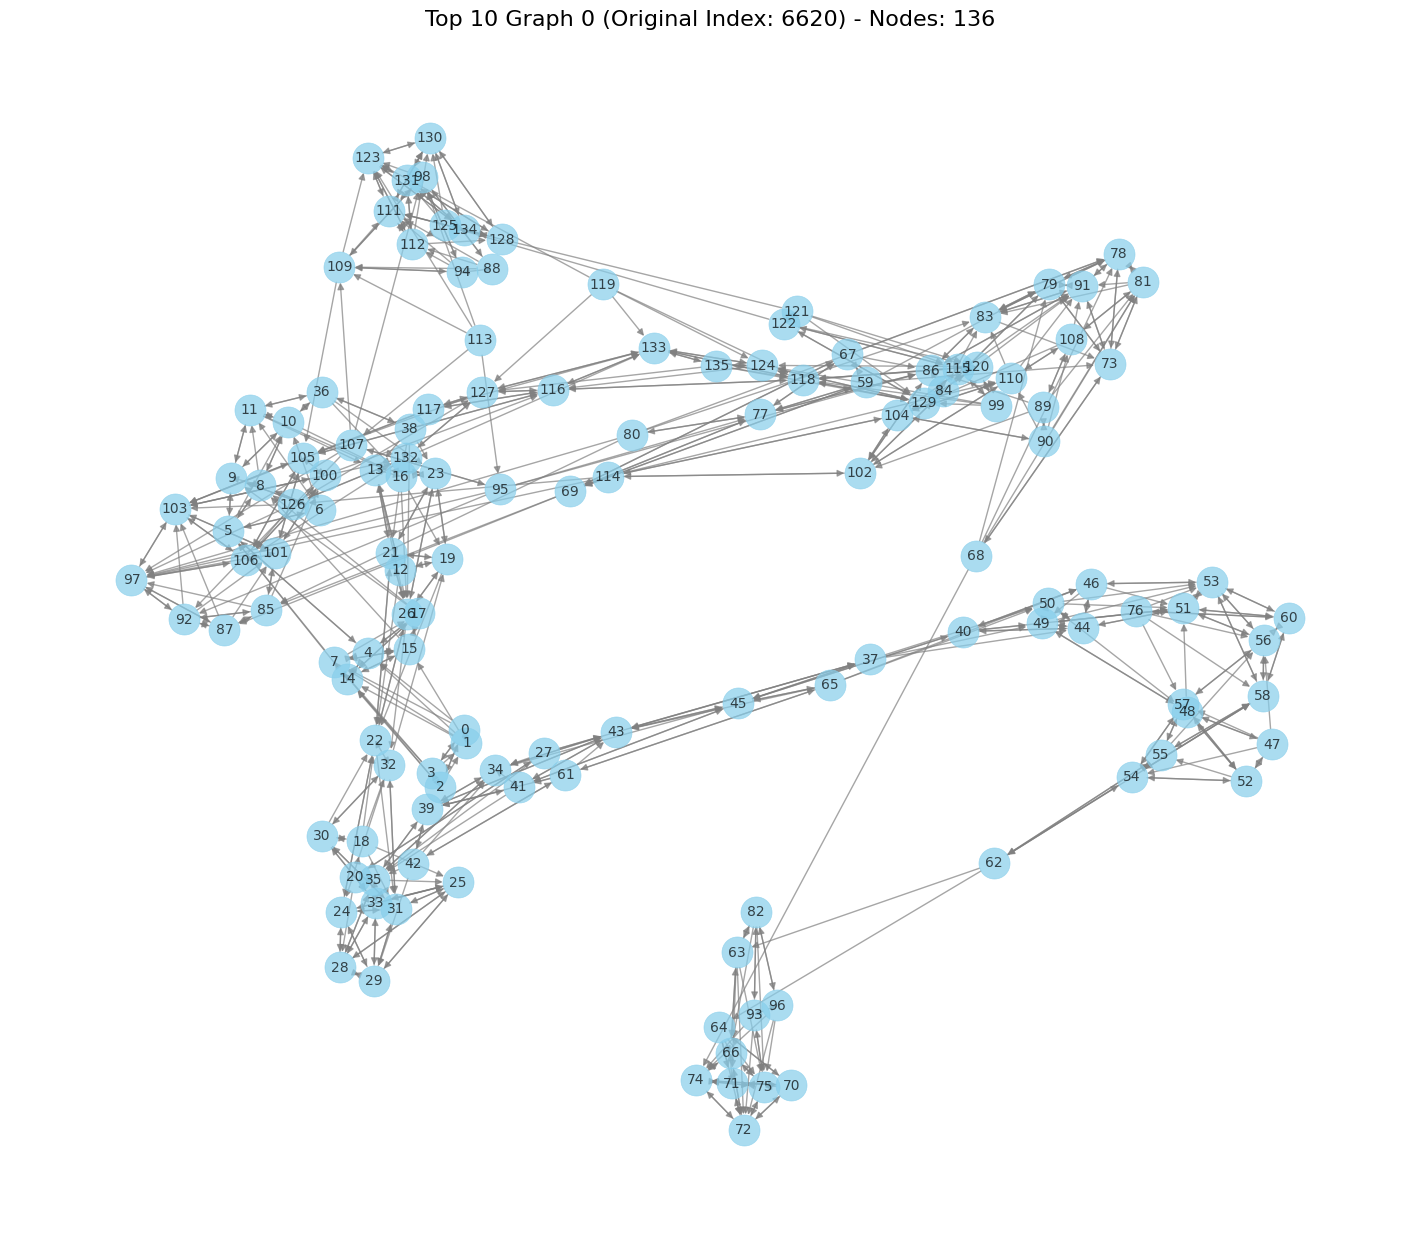

Visualized Graph 0 (Original Index: 6620) with 136 nodes.


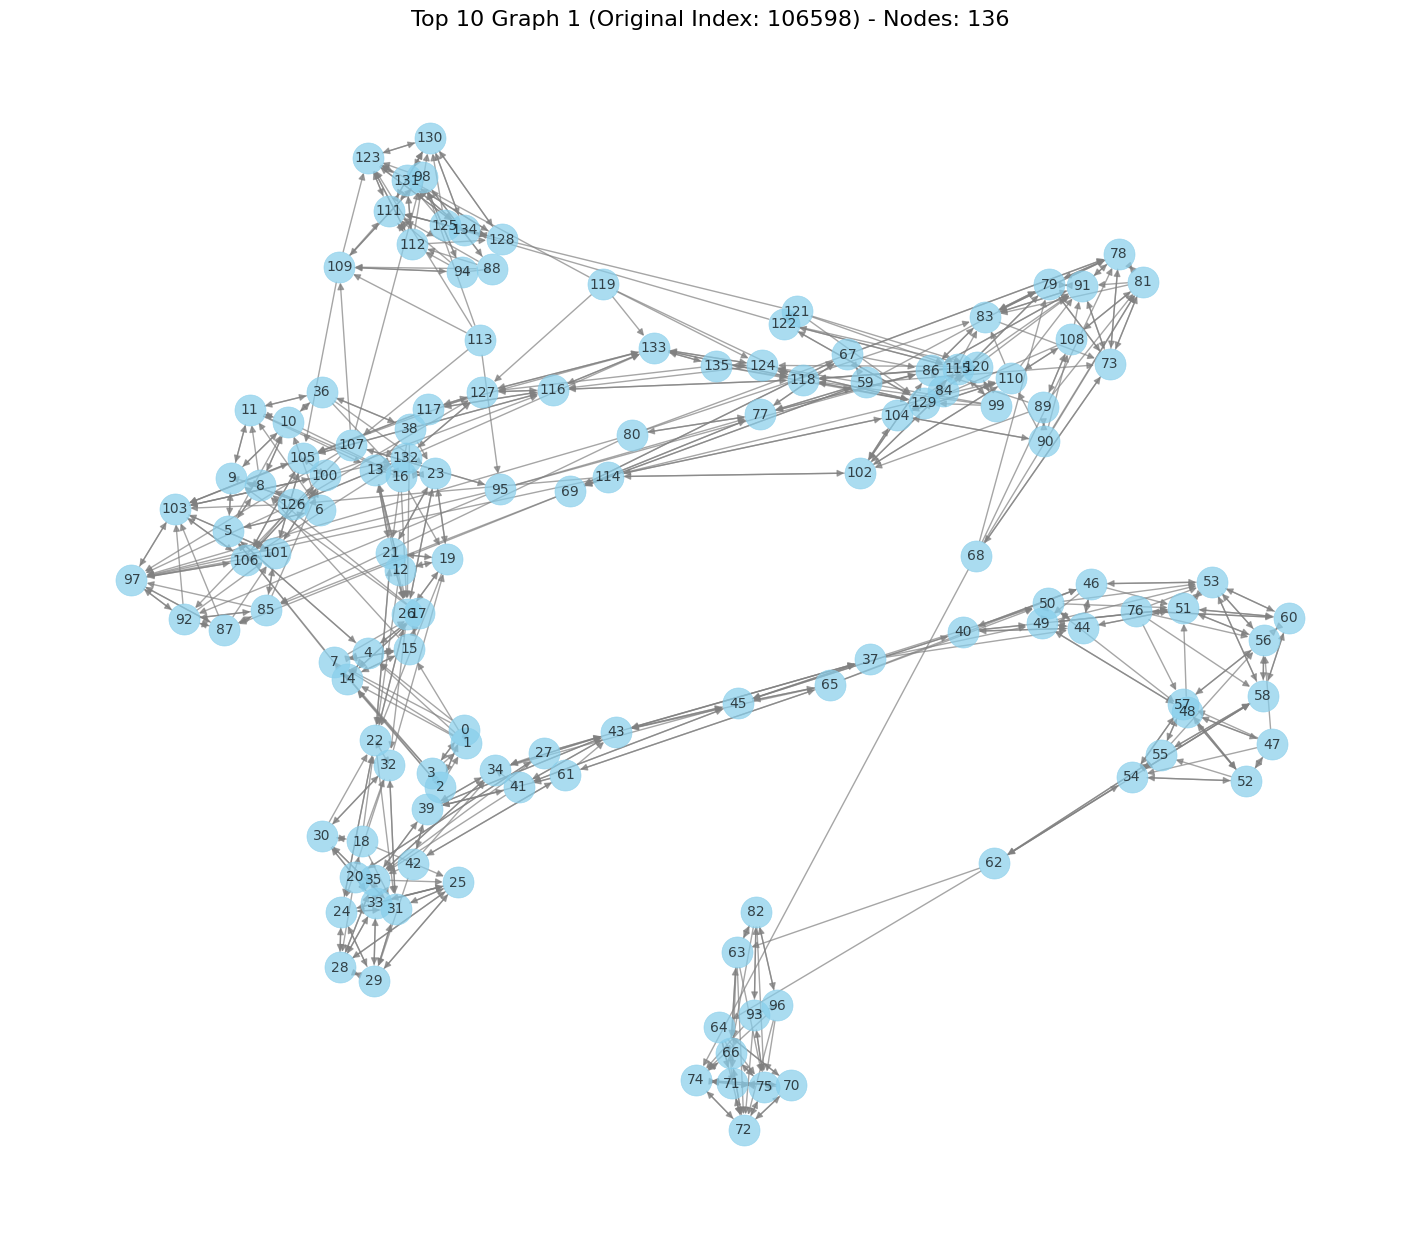

Visualized Graph 1 (Original Index: 106598) with 136 nodes.


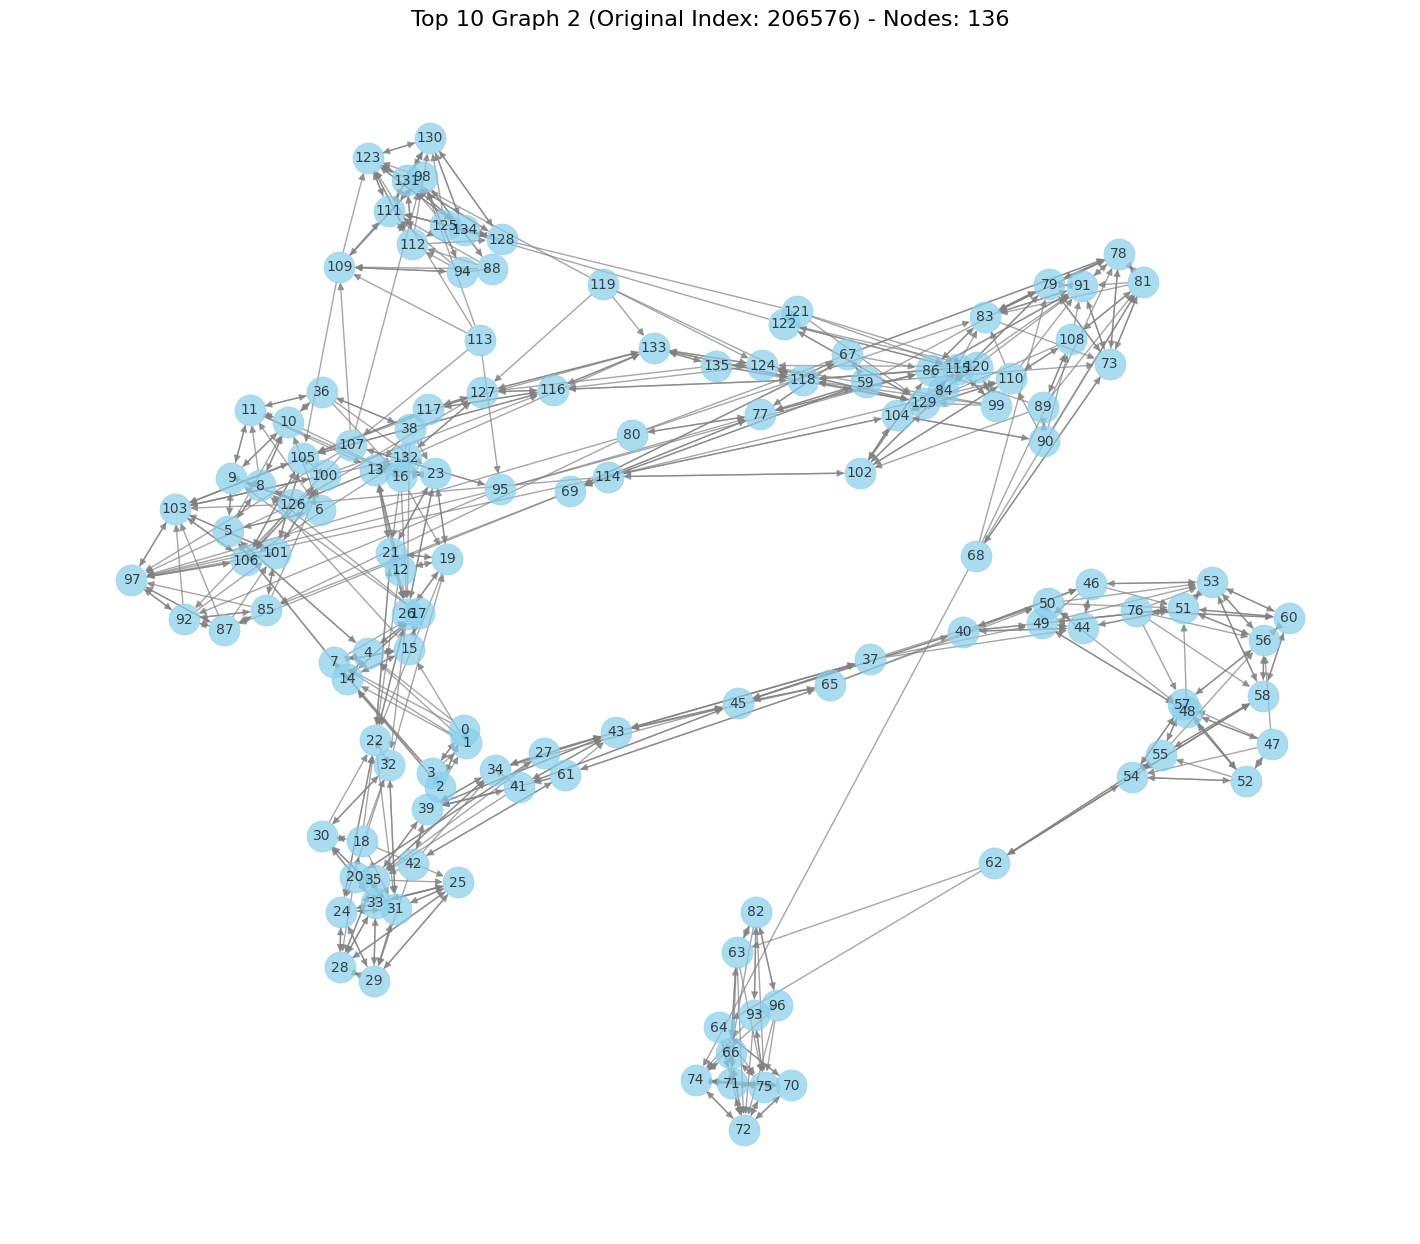

Visualized Graph 2 (Original Index: 206576) with 136 nodes.


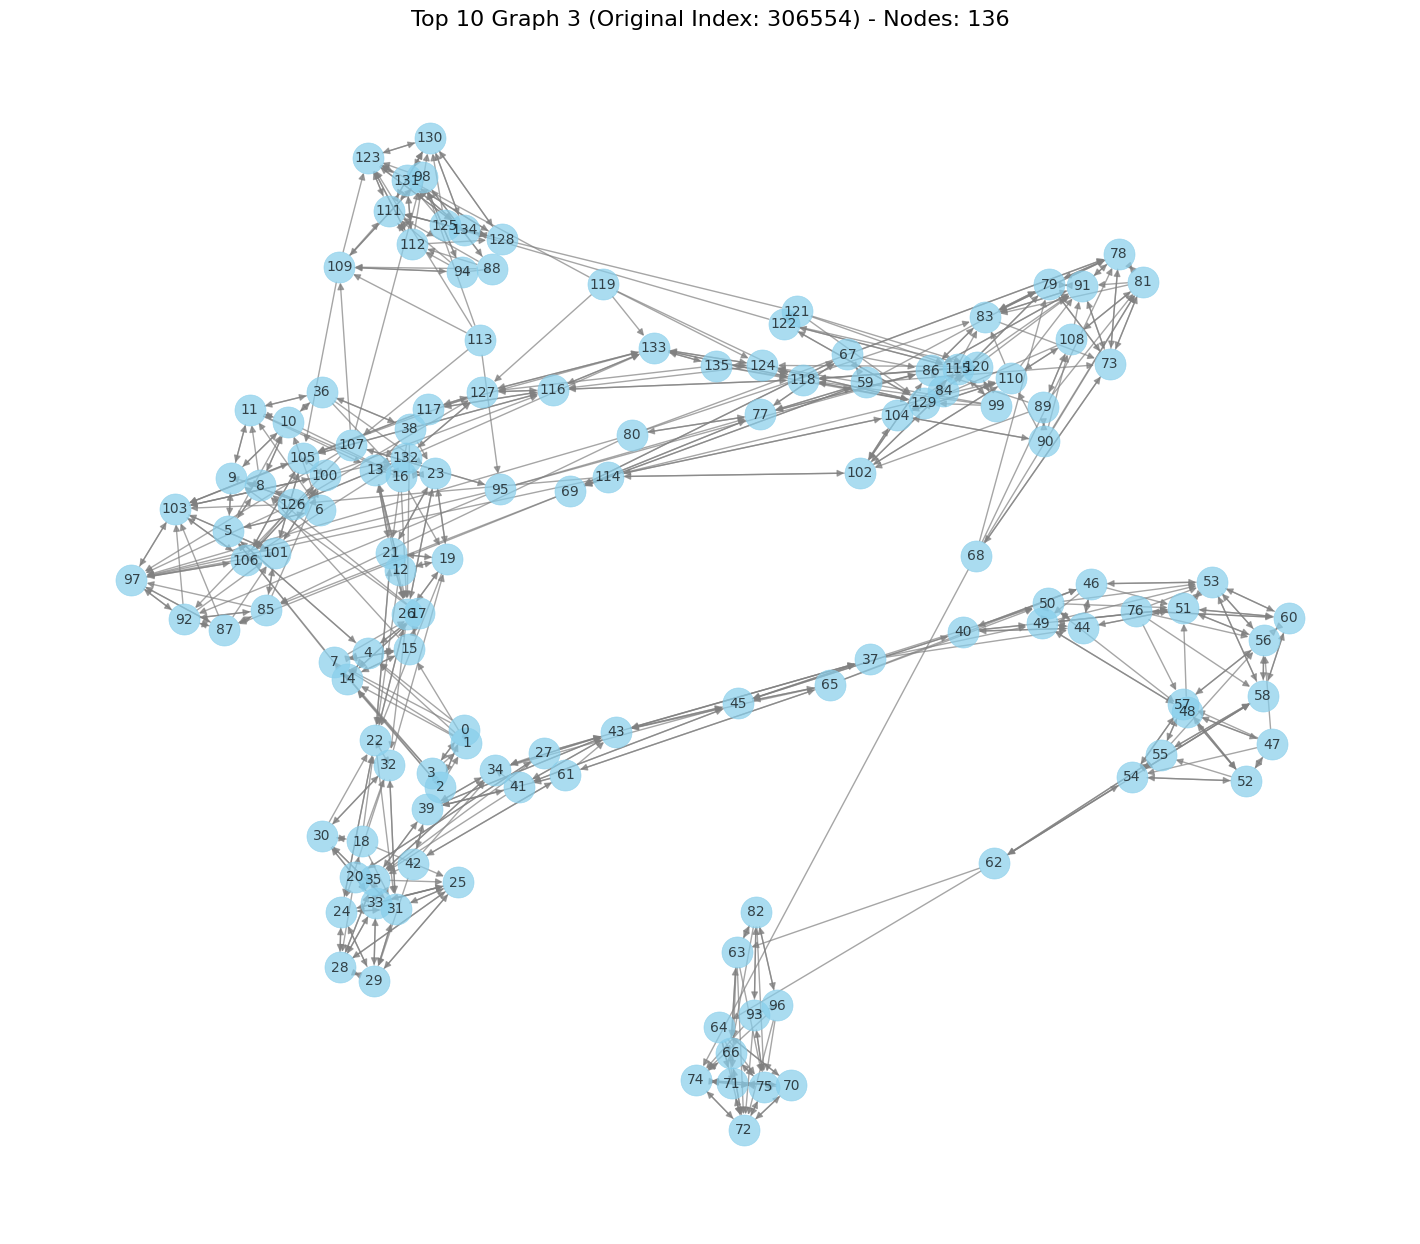

Visualized Graph 3 (Original Index: 306554) with 136 nodes.


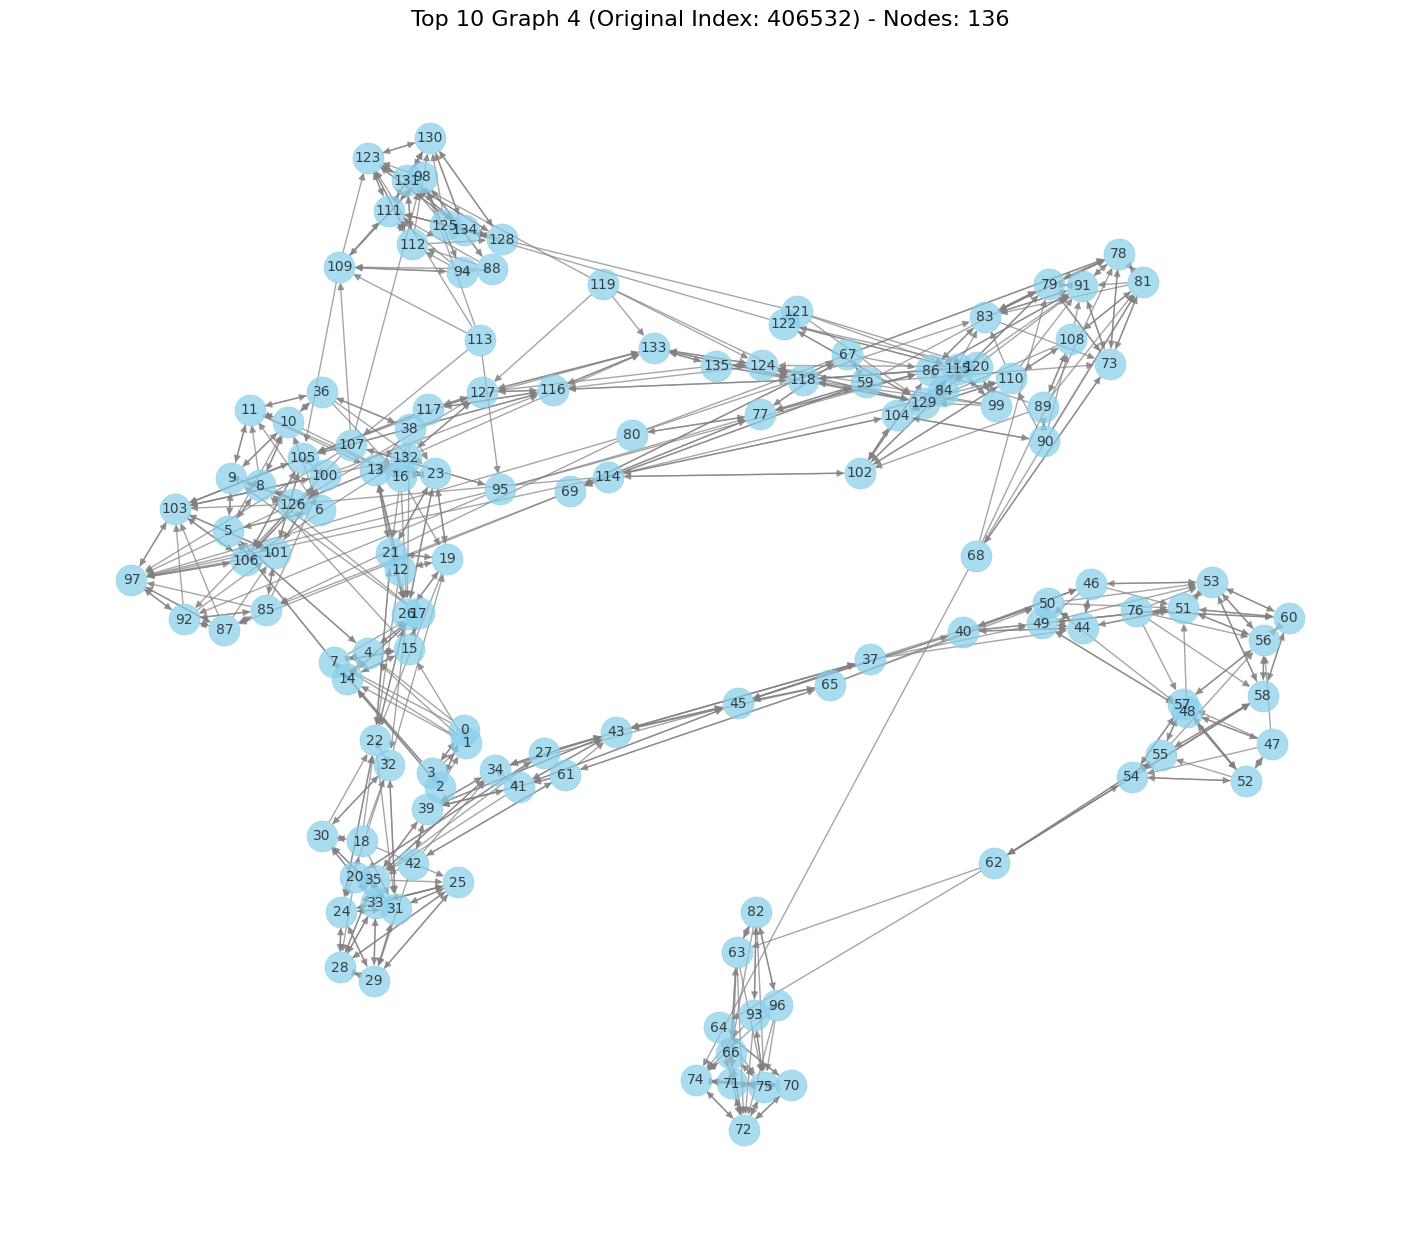

Visualized Graph 4 (Original Index: 406532) with 136 nodes.


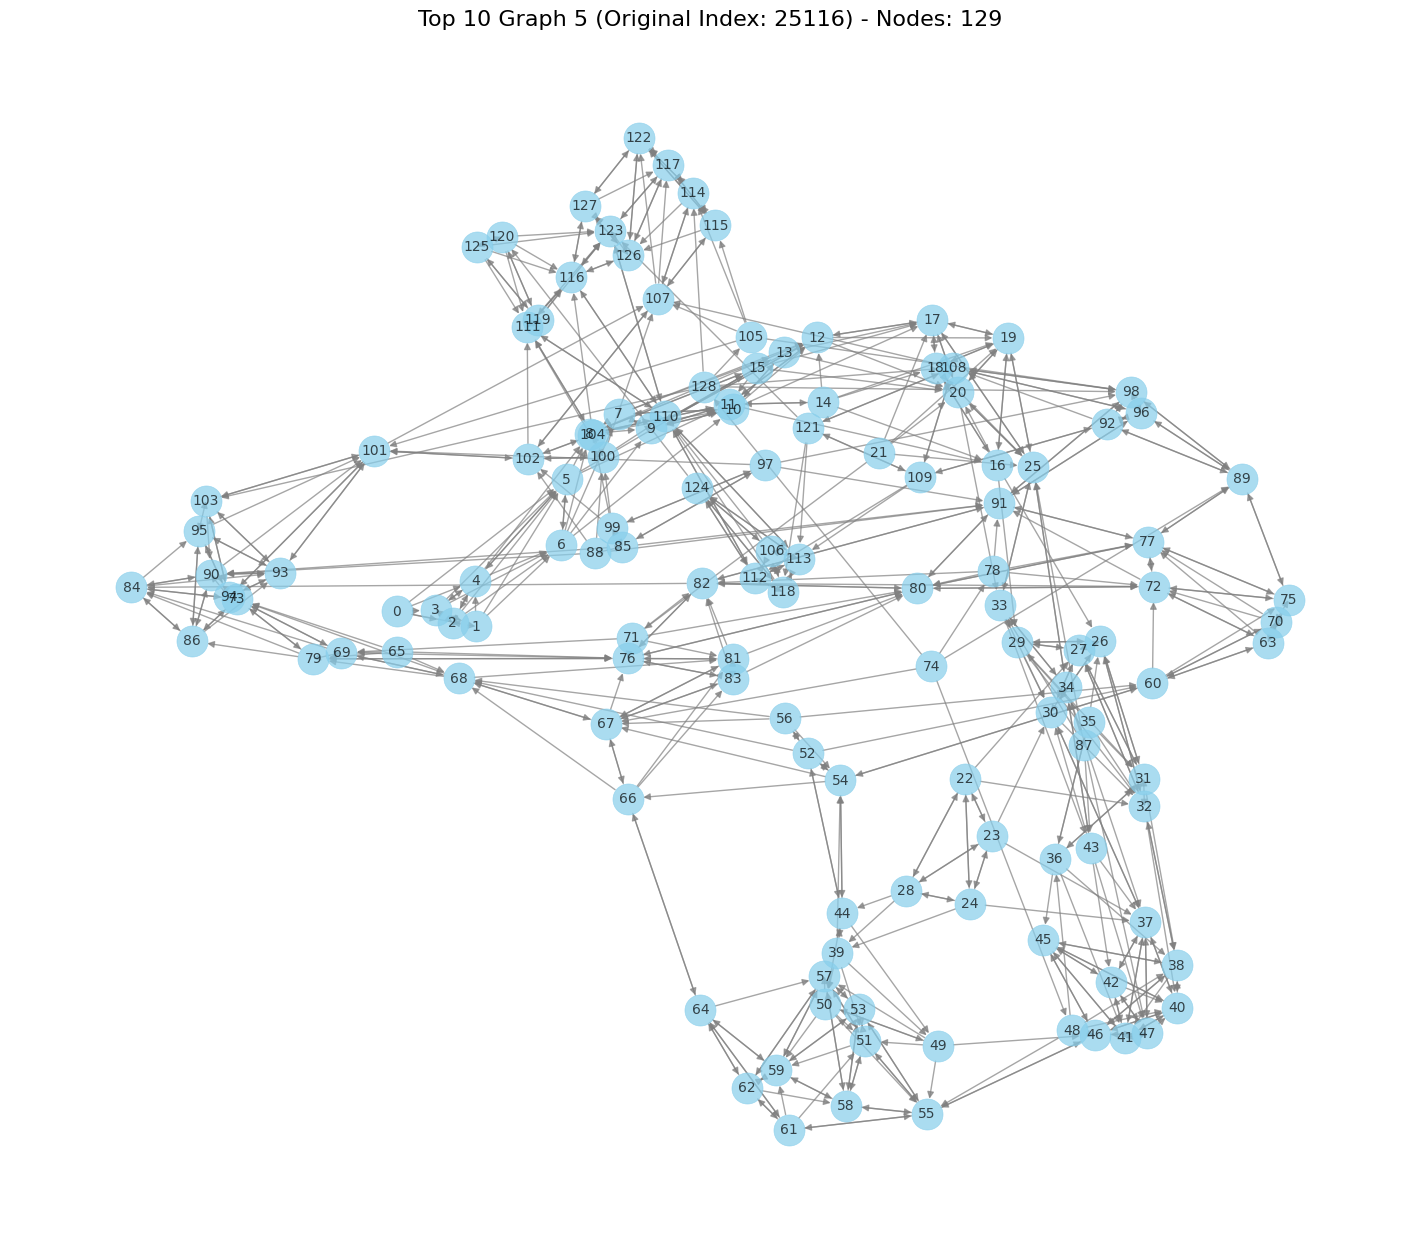

Visualized Graph 5 (Original Index: 25116) with 129 nodes.


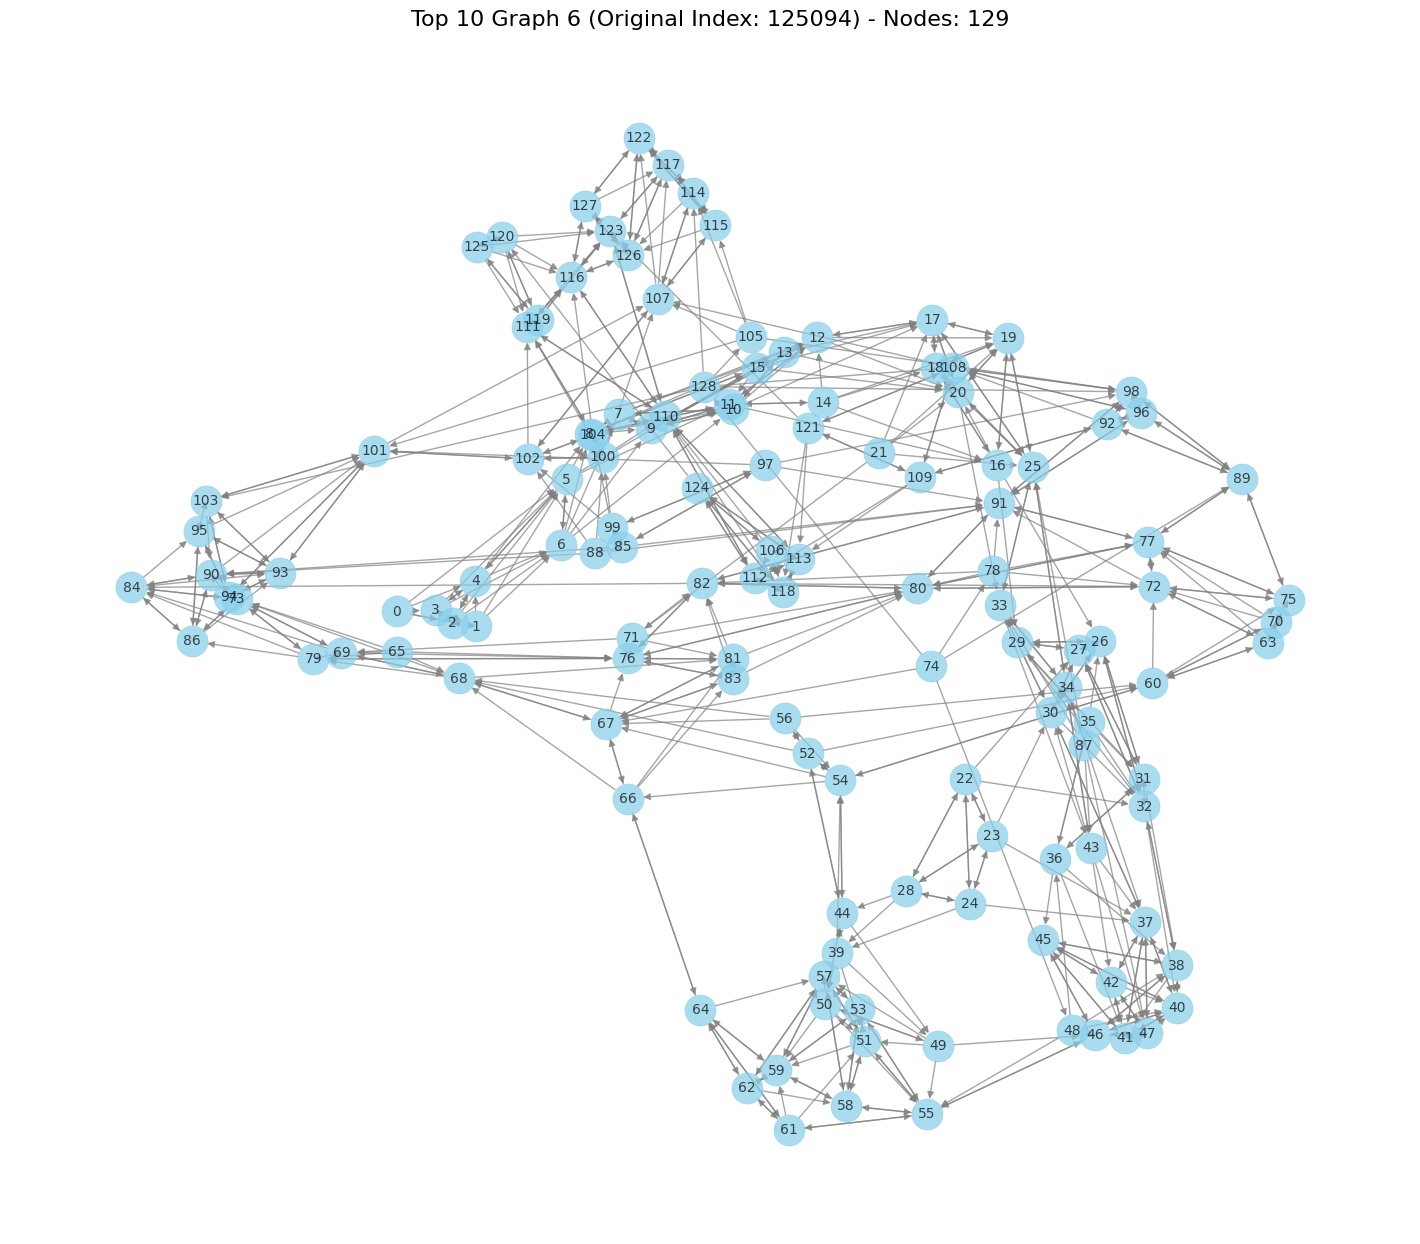

Visualized Graph 6 (Original Index: 125094) with 129 nodes.


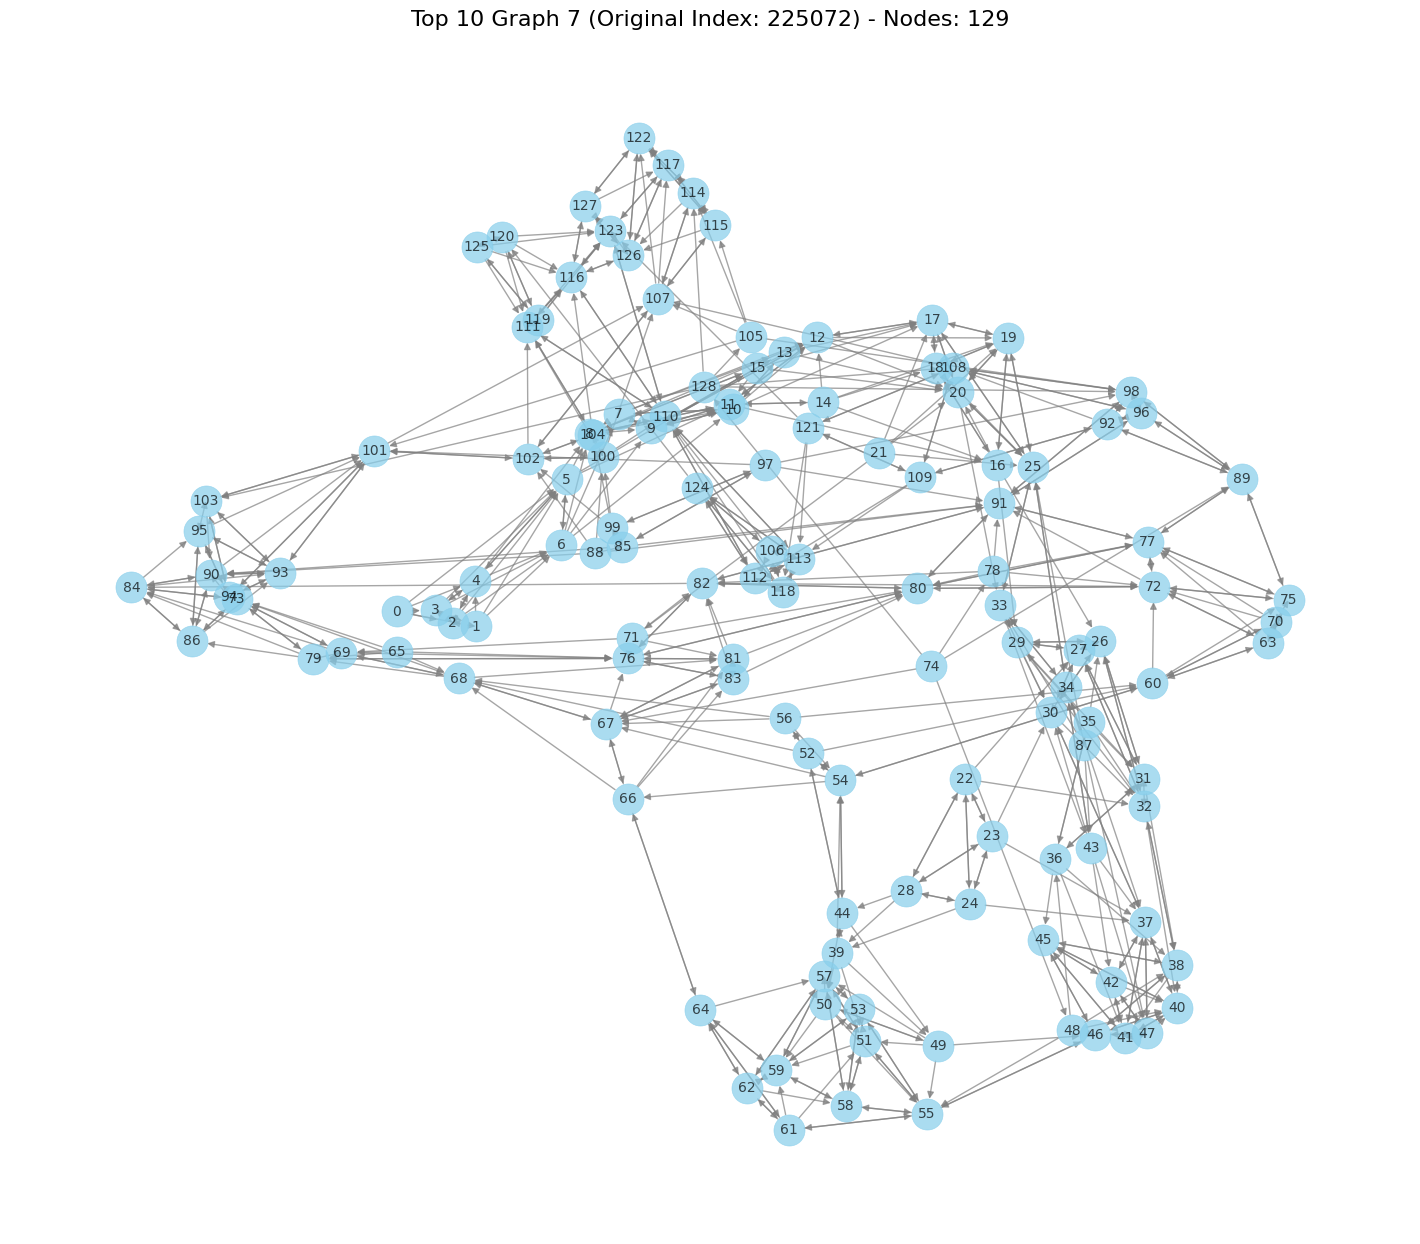

Visualized Graph 7 (Original Index: 225072) with 129 nodes.


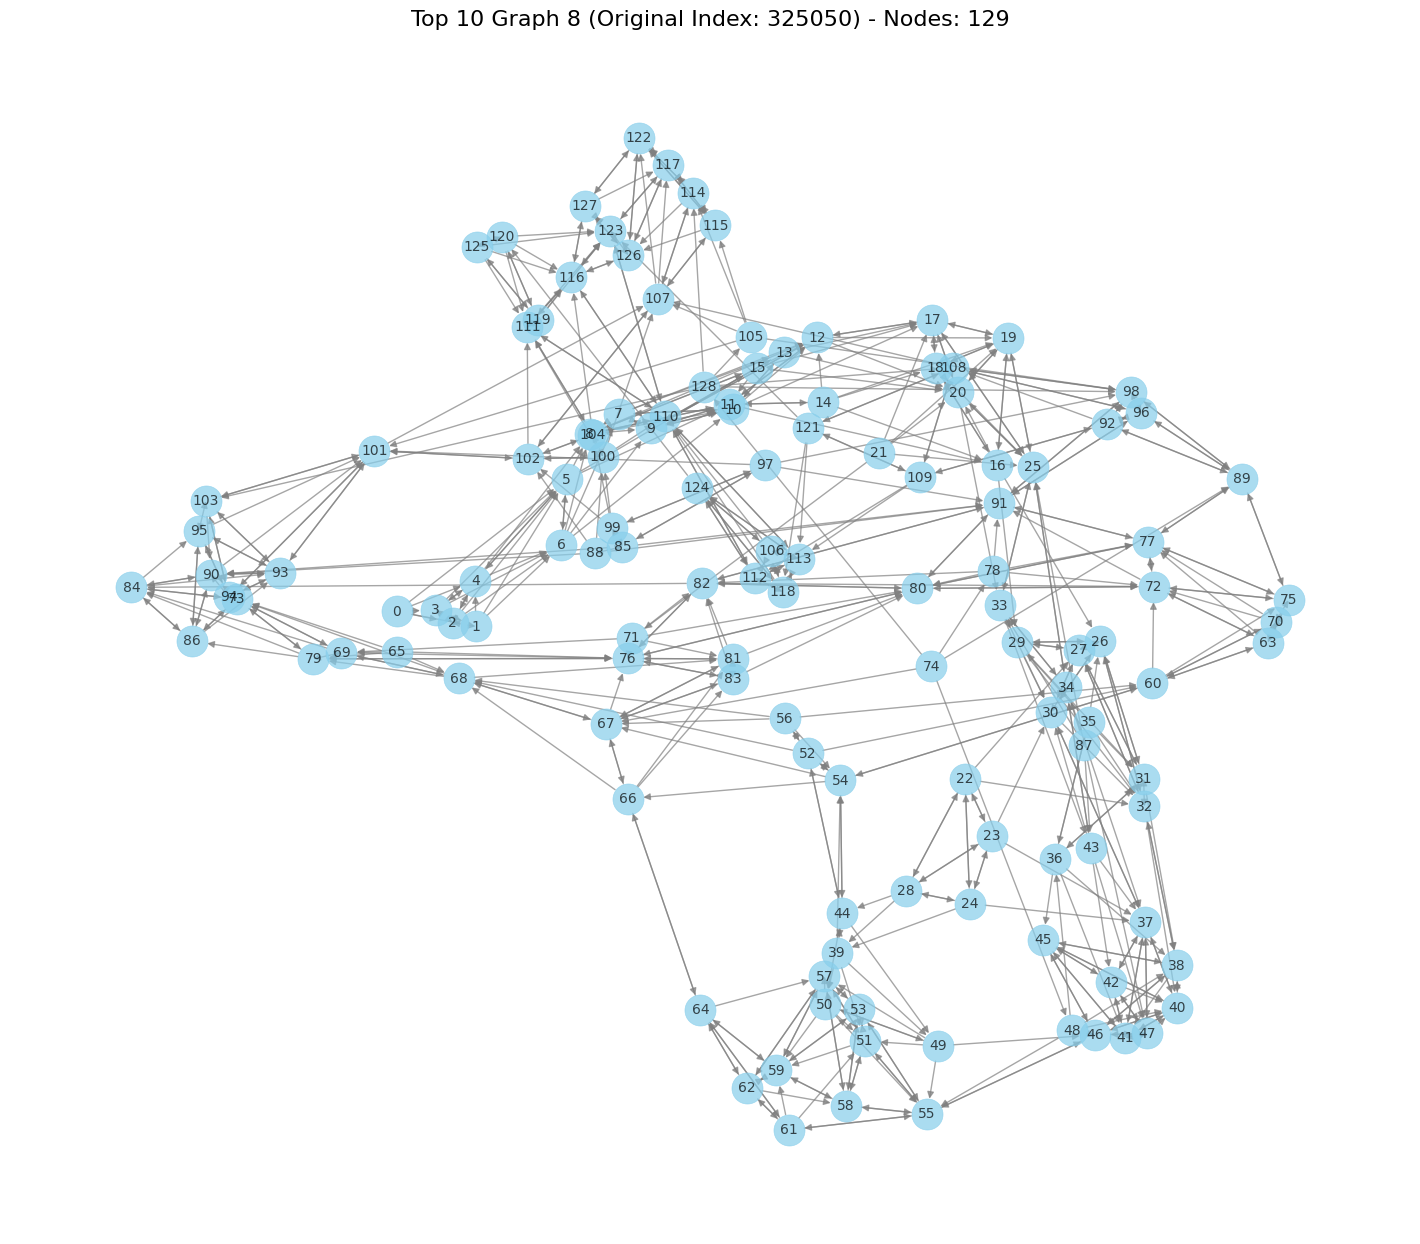

Visualized Graph 8 (Original Index: 325050) with 129 nodes.


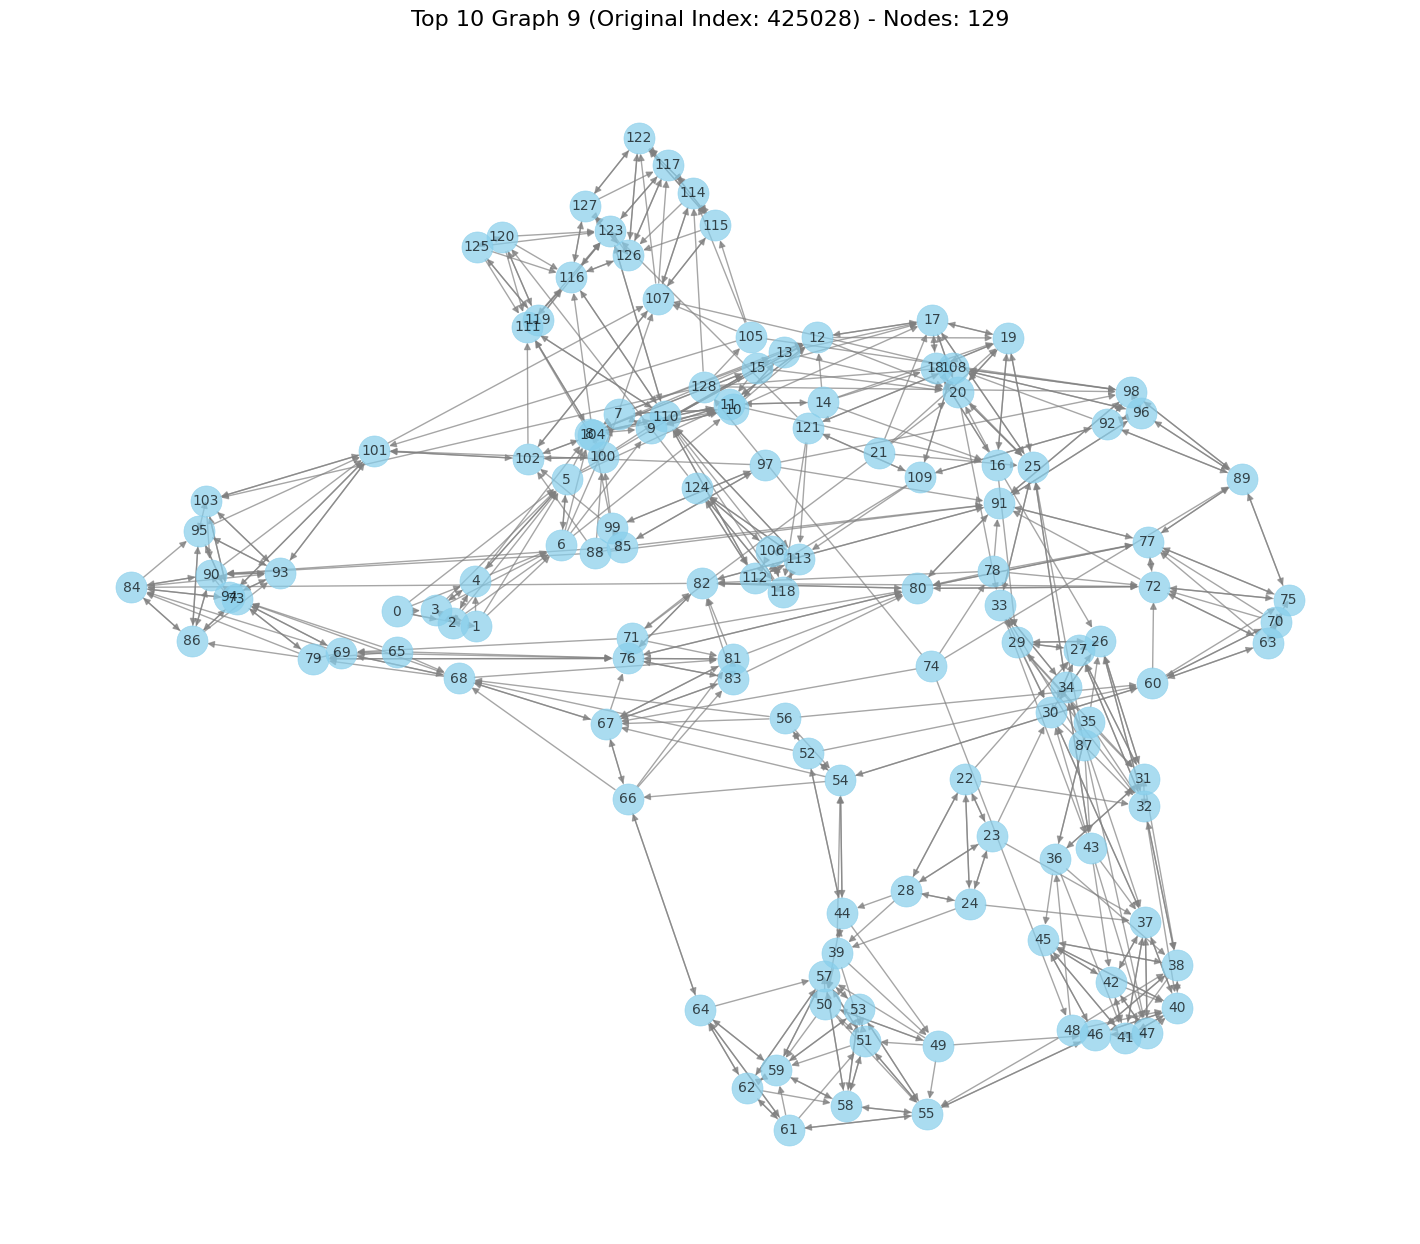

Visualized Graph 9 (Original Index: 425028) with 129 nodes.


In [4]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# Define the file path to load the top 10 graphs
output_path = './data/Multi Level Jet Tagging/top10higs.pkl'

# Function to visualize graphs with original indices
def visualize_graph_with_labels(graphs, original_indices, title_prefix):
    for idx, (g, original_idx) in enumerate(zip(graphs, original_indices)):
        nx_graph = g.to_networkx()
        
        # Use a different layout to improve spacing
        pos = nx.spring_layout(nx_graph, seed=42, k=3/len(nx_graph.nodes())**0.5)  
        
        plt.figure(figsize=(14, 12))  # Increase figure size for clarity
        nx.draw(
            nx_graph, pos,
            with_labels=True,
            labels={node: node for node in nx_graph.nodes()},
            node_size=500,  # Larger nodes
            node_color="skyblue",
            font_size=10,  # Slightly bigger font
            font_color="black",
            edge_color="gray",
            alpha=0.7,  # Slight transparency for better visibility
            linewidths=0.5
        )
        plt.title(f"{title_prefix} Graph {idx} (Original Index: {original_idx}) - Nodes: {g.num_nodes()}", fontsize=16)
        plt.show()
        print(f"Visualized Graph {idx} (Original Index: {original_idx}) with {g.num_nodes()} nodes.")

# Load the top 10 graphs from the saved file for visualization
try:
    with open(output_path, 'rb') as f:
        top_10_graphs = pickle.load(f)
    print(f"Top 10 graphs loaded successfully from {output_path}")
except Exception as e:
    print(f"Failed to load the top 10 graphs: {e}")
    exit()

# Visualize the top 10 graphs with their original indices
print("Visualizing the Top 10 graphs...")
visualize_graph_with_labels(top_10_graphs, top_10_indices, "Top 10")


# Percentage of Connected Components

/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


File loaded successfully! Total number of graphs: 499890
Frequency distribution of connected components:
1    93.026466
2     6.723479
3     0.243053
4     0.007002
Name: proportion, dtype: float64


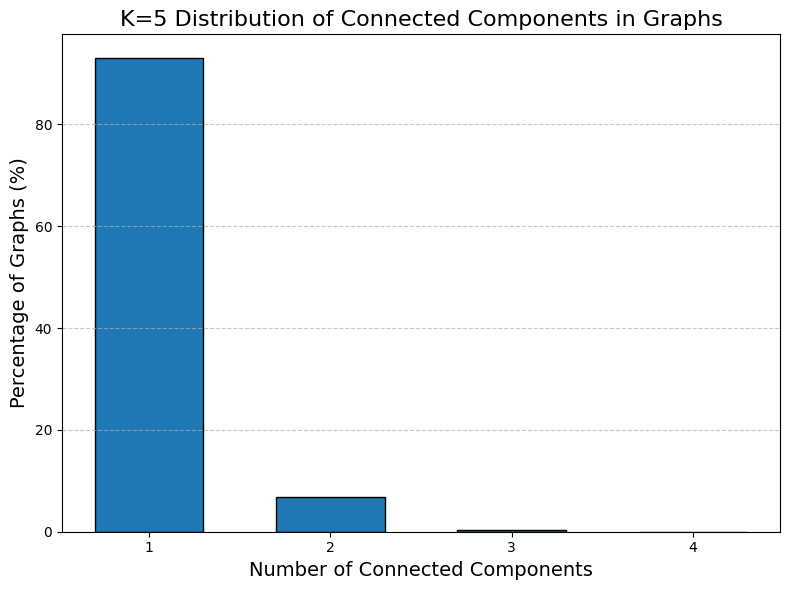

Results saved to ./connected_components_analysis.csv
Connected Components Frequency Analysis:
   Number of Connected Components  Percentage of Graphs
0                               1             93.026466
1                               2              6.723479
2                               3              0.243053
3                               4              0.007002


In [1]:
import pickle
import dgl
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved graph file
file_path = './data/Multi Level Jet Tagging/Emitter-Higgs.pkl'

try:
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    print(f"File loaded successfully! Total number of graphs: {len(graphs)}")
except Exception as e:
    print(f"Failed to load the file: {e}")
    exit()

# Function to count connected components
def count_connected_components(dgl_graph):
    nx_graph = dgl.to_networkx(dgl_graph)  # Convert DGL graph to NetworkX
    undirected_graph = nx_graph.to_undirected()  # Convert to undirected graph
    return nx.number_connected_components(undirected_graph)  # Count the number of connected components

# Analyze all graphs
graph_analysis = []
for i, graph in enumerate(graphs):
    num_components = count_connected_components(graph)
    graph_analysis.append(num_components)

# Calculate frequency distribution of connected components
component_counts = pd.Series(graph_analysis).value_counts(normalize=True) * 100
component_counts = component_counts.sort_index()

# Display frequency distribution
print("Frequency distribution of connected components:")
print(component_counts)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(component_counts.index, component_counts.values, width=0.6, edgecolor='black')
plt.xlabel('Number of Connected Components', fontsize=14)
plt.ylabel('Percentage of Graphs (%)', fontsize=14)
plt.title('K=5 Distribution of Connected Components in Graphs', fontsize=16)
plt.xticks(component_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save the results to a DataFrame
results_df = pd.DataFrame({
    'Number of Connected Components': component_counts.index,
    'Percentage of Graphs': component_counts.values
})

# Save to a CSV file
csv_path = './connected_components_analysis.csv'
results_df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Display the DataFrame
print("Connected Components Frequency Analysis:")
print(results_df)
